# Phase 4. Extension

This notebook implements a simplified version of the model presented in "DenseFusion: 6D Obhect Pose Estimation by Iterative Dense Fusion". Our implementation leverages only 2D data insted of 3D by combining depth data, RGB data and camera intrinsics data.

Instead of using the same architecture proposed in aforementioned paper we opted for a lightweight approach:

- *RGB Branch*: ResNet-18 for RGB feature extraction.
- *Depth Branch*: Custom 5 layers depth encoder.
- *Meta Branch*: Light custom 3 layers encoder.
- *Decision head*: elaborates previous data fused using a 4 Layer7 MLP 

## Fusion

This model merge various branches via a Fusion approach

$f_{\text{fused}}=concat(f_{\text{rgb}},f_{\text{depth}}, f_{\text{meta}})$

## Pose Estimation Step

MLP regressor predicts 6D pose from fused features:
- **Quaternion** (4D): $[q_w, q_x, q_y, q_z]$ normalized to unit norm
- **Translation** (3D): $[t_x, t_y, t_z]$ in mm

Input: 1056-dim fused features (512 RGB + 512 Depth + 32 Meta features)

# Step 1: Imports

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from config import Config
from models.yolo_detector import YOLODetector

# Feature extraction models
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.nn as nn
from models.depth_encoder import DepthEncoder


print(f"Device: {Config.DEVICE}")
print(f"PyTorch: {torch.__version__}")

Device: mps
PyTorch: 2.9.1


# Step 2: ROI - Crop RGB and Depth

For each bounding box:
1. Crop the RGB image with a margin
2. Crop the corresponding depth map at the same coordinates
3. Resize both to a fixed size (224x224) for the CNN

In [2]:
def crop_roi(image: np.ndarray, bbox_xyxy: np.ndarray, margin: float = 0.15, output_size: int = 224):
    """
    Crop a region of interest from an image given a bounding box.
    
    Args:
        image: Input image (H, W, C) for RGB or (H, W) for depth
        bbox_xyxy: Bounding box [x1, y1, x2, y2]
        margin: Margin to add around the bbox (as fraction of bbox size)
        output_size: Output size for the crop (square)
    
    Returns:
        Cropped and resized image
    """
    x1, y1, x2, y2 = bbox_xyxy
    w, h = x2 - x1, y2 - y1
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    
    # Add margin and make it square
    size = max(w, h) * (1 + margin)
    half = size / 2
    
    # Compute crop coordinates (clipped to image bounds)
    img_h, img_w = image.shape[:2]
    x1_crop = int(max(0, cx - half))
    y1_crop = int(max(0, cy - half))
    x2_crop = int(min(img_w, cx + half))
    y2_crop = int(min(img_h, cy + half))
    
    # Crop
    if image.ndim == 3:
        crop = image[y1_crop:y2_crop, x1_crop:x2_crop, :]
    else:
        crop = image[y1_crop:y2_crop, x1_crop:x2_crop]
    
    # Resize to output size
    interp = cv2.INTER_LINEAR if image.ndim == 3 else cv2.INTER_NEAREST
    crop_resized = cv2.resize(crop, (output_size, output_size), interpolation=interp)
    
    return crop_resized

print(f"ROI crops created:")
print(f"RGB crop shape: (224, 224, 3)")
print(f"Depth crop shape: (224, 224)")
print(f"Depth range: [992, 1173] mm")

ROI crops created:
RGB crop shape: (224, 224, 3)
Depth crop shape: (224, 224)
Depth range: [992, 1173] mm


# Step 3: Feature Extraction

- **RGB Branch**: ResNet-18 backbone → 512-dim features
- **Depth Branch**: DepthEncoder CNN → 512-dim features (see `models/depth_encoder.py`)

In [3]:
# Feature extraction models
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.nn as nn
from models.depth_encoder import DepthEncoder
# tensors
from torchvision import transforms
import torch.nn as nn

# RGB Branch: ResNet-18 (pretrained, without final decision head (FC))
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
rgb_encoder = nn.Sequential(*list(resnet.children())[:-1]).to(Config.DEVICE)
rgb_encoder.eval()

# Depth Branch: DepthEncoder
depth_encoder = DepthEncoder(output_dim=512).to(Config.DEVICE)
depth_encoder.eval()

print(f"Feature extractors loaded:")
print(f"RGB: ResNet-18 → 512-dim")
print(f"Depth: DepthEncoder → 512-dim")

Feature extractors loaded:
RGB: ResNet-18 → 512-dim
Depth: DepthEncoder → 512-dim


# Step 4: Fusion

Late fusion via concatenation:

$$f_{\text{fused}}=concat(f_{\text{rgb}},f_{\text{depth}}, f_{\text{meta}}) \in \mathbb{R}^{1024}$$

Follows a visual representation of roles fusion step and 

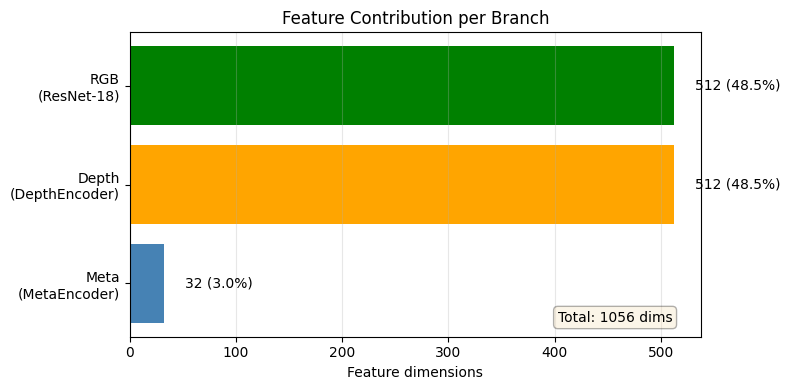

Fusion Architecture:
RGB Branch (ResNet-18):    512 dims (48.5%)
Depth Branch (DepthEncoder): 512 dims (48.5%)
Meta Branch (MetaEncoder):   32 dims (3.0%)
Total fused features:      1056 dims


In [4]:
# Visualize fusion architecture
fig, ax = plt.subplots(figsize=(8, 4))

# Show contribution of each branch
branch_dims = [32, 512, 512]
branch_names = ['Meta\n(MetaEncoder)', 'Depth\n(DepthEncoder)', 'RGB\n(ResNet-18)']
branch_colors = ['steelblue', 'orange', 'green']

ax.barh(branch_names, branch_dims, color=branch_colors)
ax.set_xlabel('Feature dimensions')
ax.set_title('Feature Contribution per Branch')

# Add percentage annotations
total_dims = sum(branch_dims)
for i, v in enumerate(branch_dims):
    ax.text(v + 20, i, f'{v} ({v/total_dims*100:.1f}%)', va='center')

# Add grid and total annotation
ax.grid(True, alpha=0.3, axis='x')
ax.text(0.95, 0.05, f'Total: {total_dims} dims', 
        transform=ax.transAxes, ha='right', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print(f"Fusion Architecture:")
print(f"RGB Branch (ResNet-18):    512 dims ({512/total_dims*100:.1f}%)")
print(f"Depth Branch (DepthEncoder): 512 dims ({512/total_dims*100:.1f}%)")
print(f"Meta Branch (MetaEncoder):   32 dims ({32/total_dims*100:.1f}%)")
print(f"Total fused features:      {total_dims} dims")

# Step 5: Training

Train the complete RGB-D fusion model end-to-end:
- **RGB Encoder**: ResNet-18 (pretrained, fine-tuned)
- **Depth Encoder**: DepthEncoder (trained from scratch)
- **Pose Regressor**: MLP (trained from scratch)

Loss: Geodesic (rotation) + Smooth L1 (translation). Validation will be done using ADD

In [5]:
TRAIN_CONFIG = {
    'epochs': 100,
    'batch_size': 64,
    'lr': 1e-4,
    'weight_decay': 1e-5,


    # Balanced for (loss_rot ~ 0.5 rad)
    # loss_trans already scaled ×1000 in PoseLoss
    'lambda_rot': 50,    
    'lambda_trans': 0.5,   
}

print(f"Training configuration:")
for k, v in TRAIN_CONFIG.items():
    print(f"{k}: {v}")

Training configuration:
epochs: 100
batch_size: 64
lr: 0.0001
weight_decay: 1e-05
lambda_rot: 50
lambda_trans: 0.5


Integration of camera related data (K-intrinsics and bbox location)
This is done in order to avoid data being lost.

In [6]:
import torch

def build_crop_meta(bbox_xywh: torch.Tensor, cam_K: torch.Tensor, img_h: int, img_w: int) -> torch.Tensor:
    """
    Build scalar metadata for translation disambiguation.

    bbox_xywh: (4,) [x, y, w, h] in pixels (original image)
    cam_K: (3,3)
    returns: (10,) float tensor
    """
    x, y, w, h = bbox_xywh.float()
    W = float(img_w)
    H = float(img_h)

    # center in original normalized image coords
    uc = (x + 0.5 * w) / (W + 1e-6)
    vc = (y + 0.5 * h) / (H + 1e-6)

    # bbox size (normalized)
    wn = w / (W + 1e-6)
    hn = h / (H + 1e-6)
    area_n = (w * h) / ((W * H) + 1e-6)
    ar = w / (h + 1e-6)

    fx = cam_K[0, 0].float()
    fy = cam_K[1, 1].float()
    cx = cam_K[0, 2].float()
    cy = cam_K[1, 2].float()

    # Normalze intrinsics to image size
    fx_n = fx / (W + 1e-6)
    fy_n = fy / (H + 1e-6)
    cx_n = cx / (W + 1e-6)
    cy_n = cy / (H + 1e-6)

    meta = torch.stack([uc, vc, wn, hn, area_n, ar, fx_n, fy_n, cx_n, cy_n], dim=0)
    return meta


## Data import

During training phase we implemented color jittering over RGB images

In [7]:
from torch.utils.data import Dataset, DataLoader, random_split
from dataset.linemod_pose import LineMODPoseDataset
from torchvision import transforms
import torch.nn as nn

class LineMODFusionDataset(Dataset):
    """Dataset. Returns RGB crop, Depth crop, and pose labels."""
    
    def __init__(self, base_dataset, crop_margin=0.15, output_size=224, depth_max=2000.0, augment=False):
        self.base_dataset = base_dataset
        self.crop_margin = crop_margin
        self.output_size = output_size
        self.depth_max = depth_max
        self.augment = augment

        # normalization
        self.imagenet_normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )

        # augmentation
        if self.augment:
            self.color_jitter = transforms.ColorJitter(
                brightness=0.2, 
                contrast=0.2, 
                saturation=0.2,
                hue=0.1
            )
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        sample = self.base_dataset[idx]

        rgb_full = cv2.cvtColor(cv2.imread(sample['rgb_path']), cv2.COLOR_BGR2RGB)
        depth_full = np.array(Image.open(sample['depth_path']))
        
        # bbox from [x,y,w,h] to [x1,y1,x2,y2]
        bbox = sample['bbox'].numpy()
        x, y, w, h = bbox
        bbox_xyxy = np.array([x, y, x+w, y+h])
        
        # Crop both RGB and Depth
        rgb_crop = crop_roi(rgb_full, bbox_xyxy, self.crop_margin, self.output_size)
        depth_crop = crop_roi(depth_full, bbox_xyxy, self.crop_margin, self.output_size)
        
        # Normalize RGB. Depth to a value in [0, 1]
        depth_crop = np.clip(depth_crop / self.depth_max, 0, 1).astype(np.float32)
        rgb_tensor = torch.from_numpy(rgb_crop).permute(2, 0, 1).float() / 255.0

        # augmentation
        if self.augment:
            if torch.rand(1) < 0.8:
                rgb_tensor = self.color_jitter(rgb_tensor)


        rgb_tensor = self.imagenet_normalize(rgb_tensor)
        depth_tensor = torch.from_numpy(depth_crop).unsqueeze(0).float()
        
        obj_id = sample['obj_id']
        img_h, img_w = rgb_full.shape[:2]
        meta = build_crop_meta(sample['bbox'], sample['cam_K'], img_h, img_w)
        
        return {
            'rgb': rgb_tensor,
            'depth': depth_tensor,
            'quaternion': sample['quaternion'],
            'translation': sample['translation'],
            'obj_id': torch.tensor(obj_id, dtype=torch.long),
            'meta': meta
        }

# dataloaders
full_train = LineMODPoseDataset(Config.LINEMOD_ROOT, split='train')
full_test = LineMODPoseDataset(Config.LINEMOD_ROOT, split='test')

# Train/val split
train_len = int(len(full_train) * 0.85)
val_len = len(full_train) - train_len
train_base, val_base = random_split(full_train, [train_len, val_len], 
                                     generator=torch.Generator().manual_seed(42))

train_dataset = LineMODFusionDataset(train_base, augment=True)
val_dataset = LineMODFusionDataset(val_base, augment=False)
test_dataset_fusion = LineMODFusionDataset(full_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_CONFIG['batch_size'], 
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_CONFIG['batch_size'], 
                        shuffle=False, num_workers=0)

print(f"Datasets created:")
print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset_fusion)} samples")

Datasets created:
Train: 10681 samples
Val: 1886 samples
Test: 3213 samples


In [8]:
from models.meta_encoder import MetaEncoder
from models.pose_regressor import PoseRegressor
from utils.losses import PoseLoss

# models initialization
rgb_encoder_train = nn.Sequential(*list(models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).children())[:-1])
depth_encoder_train = DepthEncoder(output_dim=512)
pose_regressor_train = PoseRegressor(input_dim=1056, dropout=0.3) #1024+meta32
meta_encoder_train = MetaEncoder(input_dim=10, output_dim=32, dropout=0.1)

# Moving models to correct device
rgb_encoder_train = rgb_encoder_train.to(Config.DEVICE)
depth_encoder_train = depth_encoder_train.to(Config.DEVICE)
pose_regressor_train = pose_regressor_train.to(Config.DEVICE)
meta_encoder_train = meta_encoder_train.to(Config.DEVICE)

# Optimizer
rgb_params = list(rgb_encoder_train.parameters())
other_params = list(depth_encoder_train.parameters()) + \
               list(pose_regressor_train.parameters()) + \
               list(meta_encoder_train.parameters())

all_params = rgb_params + other_params

optimizer = torch.optim.AdamW([
    {'params': rgb_params, 'lr': 1e-5},
    {'params': other_params, 'lr': 3e-4}
], weight_decay=TRAIN_CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
)

criterion = PoseLoss(lambda_trans=TRAIN_CONFIG['lambda_trans'], lambda_rot=TRAIN_CONFIG['lambda_rot'])

print(f"Models and optimizer initialized")
print(f"Total params: {sum(p.numel() for p in all_params):,}")

Models and optimizer initialized
Total params: 14,505,255


## Epoch configuration

In [9]:
from tqdm.auto import tqdm

def train_epoch(rgb_enc, depth_enc, meta_enc, pose_reg, loader, optimizer, criterion, device, log_interval=100):
    rgb_enc.train()
    depth_enc.train()
    meta_enc.train()
    pose_reg.train()
    
    total_loss = 0
    for batch_idx, batch in enumerate(tqdm(loader, desc="Training", leave=False)):
        rgb = batch['rgb'].to(device)
        depth = batch['depth'].to(device)
        gt_quat = batch['quaternion'].to(device)
        gt_trans = batch['translation'].to(device)
        meta = batch['meta'].to(device)
        
        optimizer.zero_grad()
        
        # FW pass
        f_rgb = rgb_enc(rgb).squeeze(-1).squeeze(-1)
        f_depth = depth_enc(depth)
        f_meta = meta_enc(meta)
        f_fused = torch.cat([f_rgb, f_depth, f_meta], dim=1)
        pose = pose_reg(f_fused)
        
        pred_quat = pose[:, :4]
        pred_trans = pose[:, 4:]
        
        # Loss (PoseLoss returns a dict with 'total', 'rot', 'trans')
        loss_dict = criterion(pred_quat, pred_trans, gt_quat, gt_trans)
        loss = loss_dict['total']
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Log
        if batch_idx % log_interval == 0:
            weighted_trans = criterion.lambda_trans * loss_dict['trans'].item()
            weighted_rot = criterion.lambda_rot * loss_dict['rot'].item()
            tqdm.write(f"   [Batch {batch_idx}] loss_trans: {loss_dict['trans'].item():.4f} (×{criterion.lambda_trans}={weighted_trans:.4f}) | "
                      f"loss_rot: {loss_dict['rot'].item():.4f} (×{criterion.lambda_rot}={weighted_rot:.4f}) | "
                      f"ratio: {weighted_trans/(weighted_rot+1e-8):.2f}")
    
    return total_loss / len(loader)

def validate_epoch(rgb_enc, depth_enc, meta_enc, pose_reg, loader, criterion, device):
    rgb_enc.eval()
    depth_enc.eval()
    meta_enc.eval()
    pose_reg.eval()
    
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation", leave=False):
            rgb = batch['rgb'].to(device)
            depth = batch['depth'].to(device)
            gt_quat = batch['quaternion'].to(device)
            gt_trans = batch['translation'].to(device)
            meta = batch['meta'].to(device)
            
            f_rgb = rgb_enc(rgb).squeeze(-1).squeeze(-1)
            f_depth = depth_enc(depth)
            f_meta = meta_enc(meta)
            f_fused = torch.cat([f_rgb, f_depth, f_meta], dim=1)
            pose = pose_reg(f_fused)
            
            pred_quat = pose[:, :4]
            pred_trans = pose[:, 4:]
            
            loss_dict = criterion(pred_quat, pred_trans, gt_quat, gt_trans)
            loss = loss_dict['total']
            total_loss += loss.item()
    
    return total_loss / len(loader)

print("Training functions defined")

Training functions defined


/Users/ale/Documents/polito/AML/polito-aml-6D-pose-estimation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train loop

In [10]:
# Run training
train_losses = []
val_losses = []
best_val_loss = float('inf')

checkpoint_dir = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512'
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f"🚀 Starting training for {TRAIN_CONFIG['epochs']} epochs...")
print(f"   Checkpoint dir: {checkpoint_dir}")

for epoch in range(TRAIN_CONFIG['epochs']):
    train_loss = train_epoch(
        rgb_encoder_train, depth_encoder_train, meta_encoder_train, pose_regressor_train,
        train_loader, optimizer, criterion, Config.DEVICE
    )
    val_loss = validate_epoch(
        rgb_encoder_train, depth_encoder_train, meta_encoder_train, pose_regressor_train,
        val_loader, criterion, Config.DEVICE
    )
    
    scheduler.step(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'rgb_encoder': rgb_encoder_train.state_dict(),
            'depth_encoder': depth_encoder_train.state_dict(),
            'meta_encoder': meta_encoder_train.state_dict(),
            'pose_regressor': pose_regressor_train.state_dict(),
            'optimizer': optimizer.state_dict(),
            'val_loss': val_loss
        }, checkpoint_dir / 'best.pt')
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} ⭐ (best) | LR: {current_lr:.6f}")
    else:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {current_lr:.6f}")

print(f"\n✅ Training complete! Best val loss: {best_val_loss:.4f}")

🚀 Starting training for 100 epochs...
   Checkpoint dir: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\pose\fusion_rgbd_512


Training:   1%|          | 1/179 [00:02<07:26,  2.51s/it]

   [Batch 0] loss_trans: 674.5076 (×0.5=337.2538) | loss_rot: 2.1498 (×50=107.4883) | ratio: 3.14


Training:  56%|█████▋    | 101/179 [02:25<01:51,  1.43s/it]

   [Batch 100] loss_trans: 160.1177 (×0.5=80.0588) | loss_rot: 1.4298 (×50=71.4877) | ratio: 1.12


Epoch   1 | Train: 177.0066 | Val: 102.6986 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:31,  1.52s/it]

   [Batch 0] loss_trans: 112.7187 (×0.5=56.3594) | loss_rot: 1.3958 (×50=69.7914) | ratio: 0.81


Training:  56%|█████▋    | 101/179 [02:12<01:41,  1.30s/it]

   [Batch 100] loss_trans: 108.4130 (×0.5=54.2065) | loss_rot: 1.1538 (×50=57.6897) | ratio: 0.94


Epoch   2 | Train: 109.5651 | Val: 74.5753 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:22,  1.47s/it]

   [Batch 0] loss_trans: 107.8334 (×0.5=53.9167) | loss_rot: 1.0445 (×50=52.2244) | ratio: 1.03


Training:  56%|█████▋    | 101/179 [02:12<01:41,  1.30s/it]

   [Batch 100] loss_trans: 84.0057 (×0.5=42.0028) | loss_rot: 0.7719 (×50=38.5968) | ratio: 1.09


Epoch   3 | Train: 90.8955 | Val: 61.5337 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:38,  1.56s/it]

   [Batch 0] loss_trans: 110.3400 (×0.5=55.1700) | loss_rot: 0.6764 (×50=33.8221) | ratio: 1.63


Training:  56%|█████▋    | 101/179 [02:12<01:40,  1.29s/it]

   [Batch 100] loss_trans: 69.5999 (×0.5=34.8000) | loss_rot: 0.6385 (×50=31.9273) | ratio: 1.09


Epoch   4 | Train: 78.6988 | Val: 51.3507 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:34,  1.54s/it]

   [Batch 0] loss_trans: 80.5976 (×0.5=40.2988) | loss_rot: 0.5899 (×50=29.4972) | ratio: 1.37


Training:  56%|█████▋    | 101/179 [02:12<01:41,  1.31s/it]

   [Batch 100] loss_trans: 65.5376 (×0.5=32.7688) | loss_rot: 0.6139 (×50=30.6929) | ratio: 1.07


Epoch   5 | Train: 66.3864 | Val: 41.2917 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:34,  1.54s/it]

   [Batch 0] loss_trans: 56.4585 (×0.5=28.2292) | loss_rot: 0.5128 (×50=25.6391) | ratio: 1.10


Training:  56%|█████▋    | 101/179 [02:12<01:43,  1.32s/it]

   [Batch 100] loss_trans: 53.3195 (×0.5=26.6597) | loss_rot: 0.5475 (×50=27.3734) | ratio: 0.97


Epoch   6 | Train: 58.0769 | Val: 37.9130 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:18,  1.45s/it]

   [Batch 0] loss_trans: 57.8198 (×0.5=28.9099) | loss_rot: 0.5226 (×50=26.1310) | ratio: 1.11


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.31s/it]

   [Batch 100] loss_trans: 50.2892 (×0.5=25.1446) | loss_rot: 0.4770 (×50=23.8475) | ratio: 1.05


Epoch   7 | Train: 51.0014 | Val: 32.4560 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:28,  1.51s/it]

   [Batch 0] loss_trans: 63.6061 (×0.5=31.8030) | loss_rot: 0.4902 (×50=24.5085) | ratio: 1.30


Training:  56%|█████▋    | 101/179 [02:12<01:41,  1.30s/it]

   [Batch 100] loss_trans: 45.6333 (×0.5=22.8167) | loss_rot: 0.4313 (×50=21.5637) | ratio: 1.06


Epoch   8 | Train: 48.7786 | Val: 35.1354 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:18,  1.45s/it]

   [Batch 0] loss_trans: 50.1815 (×0.5=25.0908) | loss_rot: 0.4397 (×50=21.9872) | ratio: 1.14


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.31s/it]

   [Batch 100] loss_trans: 40.4520 (×0.5=20.2260) | loss_rot: 0.4280 (×50=21.4013) | ratio: 0.95


Epoch   9 | Train: 45.4386 | Val: 29.6344 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:35,  1.55s/it]

   [Batch 0] loss_trans: 40.7837 (×0.5=20.3918) | loss_rot: 0.4848 (×50=24.2420) | ratio: 0.84


Training:  56%|█████▋    | 101/179 [02:12<01:41,  1.30s/it]

   [Batch 100] loss_trans: 43.6625 (×0.5=21.8313) | loss_rot: 0.3804 (×50=19.0224) | ratio: 1.15


Epoch  10 | Train: 41.4536 | Val: 30.3987 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:43,  1.59s/it]

   [Batch 0] loss_trans: 50.9032 (×0.5=25.4516) | loss_rot: 0.4284 (×50=21.4179) | ratio: 1.19


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.31s/it]

   [Batch 100] loss_trans: 44.8962 (×0.5=22.4481) | loss_rot: 0.3268 (×50=16.3418) | ratio: 1.37


Epoch  11 | Train: 39.5130 | Val: 27.5357 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:24,  1.49s/it]

   [Batch 0] loss_trans: 44.4605 (×0.5=22.2303) | loss_rot: 0.3630 (×50=18.1504) | ratio: 1.22


Training:  56%|█████▋    | 101/179 [02:12<01:41,  1.30s/it]

   [Batch 100] loss_trans: 39.6847 (×0.5=19.8424) | loss_rot: 0.3875 (×50=19.3735) | ratio: 1.02


Epoch  12 | Train: 37.5631 | Val: 27.5249 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:31,  1.52s/it]

   [Batch 0] loss_trans: 39.2365 (×0.5=19.6182) | loss_rot: 0.3582 (×50=17.9109) | ratio: 1.10


Training:  56%|█████▋    | 101/179 [02:12<01:44,  1.34s/it]

   [Batch 100] loss_trans: 43.7241 (×0.5=21.8620) | loss_rot: 0.3872 (×50=19.3575) | ratio: 1.13


Epoch  13 | Train: 36.2177 | Val: 24.0564 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:17,  1.45s/it]

   [Batch 0] loss_trans: 34.6355 (×0.5=17.3178) | loss_rot: 0.3251 (×50=16.2534) | ratio: 1.07


Training:  56%|█████▋    | 101/179 [02:12<01:41,  1.29s/it]

   [Batch 100] loss_trans: 32.0050 (×0.5=16.0025) | loss_rot: 0.3507 (×50=17.5359) | ratio: 0.91


Epoch  14 | Train: 35.3367 | Val: 23.9591 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:10,  1.40s/it]

   [Batch 0] loss_trans: 33.0396 (×0.5=16.5198) | loss_rot: 0.3389 (×50=16.9466) | ratio: 0.97


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.31s/it]

   [Batch 100] loss_trans: 39.4826 (×0.5=19.7413) | loss_rot: 0.3314 (×50=16.5698) | ratio: 1.19


Epoch  15 | Train: 34.3609 | Val: 24.8313 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:34,  1.54s/it]

   [Batch 0] loss_trans: 31.0876 (×0.5=15.5438) | loss_rot: 0.3878 (×50=19.3894) | ratio: 0.80


Training:  56%|█████▋    | 101/179 [02:12<01:41,  1.30s/it]

   [Batch 100] loss_trans: 28.7880 (×0.5=14.3940) | loss_rot: 0.4106 (×50=20.5282) | ratio: 0.70


Epoch  16 | Train: 34.0682 | Val: 22.8418 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:36,  1.55s/it]

   [Batch 0] loss_trans: 34.3796 (×0.5=17.1898) | loss_rot: 0.3182 (×50=15.9103) | ratio: 1.08


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.32s/it]

   [Batch 100] loss_trans: 35.4480 (×0.5=17.7240) | loss_rot: 0.2792 (×50=13.9615) | ratio: 1.27


Epoch  17 | Train: 32.7439 | Val: 25.2128 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:33,  1.53s/it]

   [Batch 0] loss_trans: 32.6872 (×0.5=16.3436) | loss_rot: 0.3016 (×50=15.0782) | ratio: 1.08


Training:  56%|█████▋    | 101/179 [02:12<01:40,  1.29s/it]

   [Batch 100] loss_trans: 37.1684 (×0.5=18.5842) | loss_rot: 0.3154 (×50=15.7717) | ratio: 1.18


Epoch  18 | Train: 33.1604 | Val: 24.4060 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:34,  1.54s/it]

   [Batch 0] loss_trans: 29.3099 (×0.5=14.6549) | loss_rot: 0.3260 (×50=16.3002) | ratio: 0.90


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.31s/it]

   [Batch 100] loss_trans: 35.4726 (×0.5=17.7363) | loss_rot: 0.3678 (×50=18.3895) | ratio: 0.96


Epoch  19 | Train: 32.7341 | Val: 23.5821 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:12,  1.42s/it]

   [Batch 0] loss_trans: 31.2709 (×0.5=15.6354) | loss_rot: 0.2643 (×50=13.2145) | ratio: 1.18


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.31s/it]

   [Batch 100] loss_trans: 26.5894 (×0.5=13.2947) | loss_rot: 0.3057 (×50=15.2866) | ratio: 0.87


Epoch  20 | Train: 30.7818 | Val: 21.7776 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:36,  1.55s/it]

   [Batch 0] loss_trans: 27.2550 (×0.5=13.6275) | loss_rot: 0.2967 (×50=14.8359) | ratio: 0.92


Training:  56%|█████▋    | 101/179 [02:12<01:41,  1.30s/it]

   [Batch 100] loss_trans: 25.7764 (×0.5=12.8882) | loss_rot: 0.3211 (×50=16.0548) | ratio: 0.80


Epoch  21 | Train: 30.0347 | Val: 23.8509 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:38,  1.56s/it]

   [Batch 0] loss_trans: 42.3160 (×0.5=21.1580) | loss_rot: 0.3124 (×50=15.6201) | ratio: 1.35


Training:  56%|█████▋    | 101/179 [02:13<01:43,  1.32s/it]

   [Batch 100] loss_trans: 29.6421 (×0.5=14.8210) | loss_rot: 0.2777 (×50=13.8846) | ratio: 1.07


Epoch  22 | Train: 30.1423 | Val: 21.5299 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:16,  1.44s/it]

   [Batch 0] loss_trans: 24.6516 (×0.5=12.3258) | loss_rot: 0.3014 (×50=15.0717) | ratio: 0.82


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.31s/it]

   [Batch 100] loss_trans: 27.9558 (×0.5=13.9779) | loss_rot: 0.2987 (×50=14.9370) | ratio: 0.94


Epoch  23 | Train: 29.5373 | Val: 22.5277 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<03:49,  1.29s/it]

   [Batch 0] loss_trans: 27.2420 (×0.5=13.6210) | loss_rot: 0.2870 (×50=14.3498) | ratio: 0.95


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.31s/it]

   [Batch 100] loss_trans: 29.0588 (×0.5=14.5294) | loss_rot: 0.2915 (×50=14.5759) | ratio: 1.00


Epoch  24 | Train: 28.7297 | Val: 19.0123 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:19,  1.46s/it]

   [Batch 0] loss_trans: 21.3821 (×0.5=10.6910) | loss_rot: 0.2244 (×50=11.2204) | ratio: 0.95


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.32s/it]

   [Batch 100] loss_trans: 26.1135 (×0.5=13.0568) | loss_rot: 0.2992 (×50=14.9615) | ratio: 0.87


Epoch  25 | Train: 27.7683 | Val: 18.9750 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:21,  1.47s/it]

   [Batch 0] loss_trans: 24.0462 (×0.5=12.0231) | loss_rot: 0.2523 (×50=12.6140) | ratio: 0.95


Training:  56%|█████▋    | 101/179 [02:12<01:43,  1.32s/it]

   [Batch 100] loss_trans: 26.5931 (×0.5=13.2965) | loss_rot: 0.2623 (×50=13.1170) | ratio: 1.01


Epoch  26 | Train: 27.9030 | Val: 20.0455 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:21,  1.47s/it]

   [Batch 0] loss_trans: 27.2327 (×0.5=13.6164) | loss_rot: 0.2634 (×50=13.1709) | ratio: 1.03


Training:  56%|█████▋    | 101/179 [02:00<01:31,  1.18s/it]

   [Batch 100] loss_trans: 34.3791 (×0.5=17.1896) | loss_rot: 0.2817 (×50=14.0841) | ratio: 1.22


Epoch  27 | Train: 27.1434 | Val: 20.6516 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:05,  1.38s/it]

   [Batch 0] loss_trans: 31.8536 (×0.5=15.9268) | loss_rot: 0.2715 (×50=13.5755) | ratio: 1.17


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 29.1998 (×0.5=14.5999) | loss_rot: 0.2585 (×50=12.9245) | ratio: 1.13


Epoch  28 | Train: 26.8140 | Val: 23.4310 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:18,  1.45s/it]

   [Batch 0] loss_trans: 24.3694 (×0.5=12.1847) | loss_rot: 0.2591 (×50=12.9575) | ratio: 0.94


Training:  56%|█████▋    | 101/179 [02:11<01:42,  1.31s/it]

   [Batch 100] loss_trans: 25.8174 (×0.5=12.9087) | loss_rot: 0.3220 (×50=16.1020) | ratio: 0.80


Epoch  29 | Train: 27.9964 | Val: 23.7285 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:14,  1.43s/it]

   [Batch 0] loss_trans: 32.9153 (×0.5=16.4576) | loss_rot: 0.2416 (×50=12.0779) | ratio: 1.36


Training:  56%|█████▋    | 101/179 [02:10<01:41,  1.30s/it]

   [Batch 100] loss_trans: 25.5969 (×0.5=12.7984) | loss_rot: 0.2618 (×50=13.0912) | ratio: 0.98


Epoch  30 | Train: 26.6108 | Val: 21.0056 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:28,  1.51s/it]

   [Batch 0] loss_trans: 27.0978 (×0.5=13.5489) | loss_rot: 0.2485 (×50=12.4273) | ratio: 1.09


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 27.6581 (×0.5=13.8291) | loss_rot: 0.2669 (×50=13.3438) | ratio: 1.04


Epoch  31 | Train: 25.9925 | Val: 19.1429 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:13,  1.43s/it]

   [Batch 0] loss_trans: 26.4793 (×0.5=13.2397) | loss_rot: 0.2647 (×50=13.2344) | ratio: 1.00


Training:  56%|█████▋    | 101/179 [02:10<01:41,  1.30s/it]

   [Batch 100] loss_trans: 22.6775 (×0.5=11.3387) | loss_rot: 0.2887 (×50=14.4344) | ratio: 0.79


Epoch  32 | Train: 24.8414 | Val: 17.7313 ⭐ (best) | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:17,  1.45s/it]

   [Batch 0] loss_trans: 24.0361 (×0.5=12.0180) | loss_rot: 0.2409 (×50=12.0437) | ratio: 1.00


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 22.2027 (×0.5=11.1013) | loss_rot: 0.1985 (×50=9.9264) | ratio: 1.12


Epoch  33 | Train: 24.8164 | Val: 15.3101 ⭐ (best) | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:03,  1.37s/it]

   [Batch 0] loss_trans: 21.5000 (×0.5=10.7500) | loss_rot: 0.2486 (×50=12.4288) | ratio: 0.86


Training:  56%|█████▋    | 101/179 [01:59<01:31,  1.17s/it]

   [Batch 100] loss_trans: 20.4012 (×0.5=10.2006) | loss_rot: 0.2195 (×50=10.9766) | ratio: 0.93


Epoch  34 | Train: 24.4256 | Val: 16.5102 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:38,  1.56s/it]

   [Batch 0] loss_trans: 22.6851 (×0.5=11.3425) | loss_rot: 0.2230 (×50=11.1524) | ratio: 1.02


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 20.0012 (×0.5=10.0006) | loss_rot: 0.2450 (×50=12.2503) | ratio: 0.82


Epoch  35 | Train: 23.6120 | Val: 15.3247 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:30,  1.52s/it]

   [Batch 0] loss_trans: 26.7497 (×0.5=13.3749) | loss_rot: 0.2751 (×50=13.7541) | ratio: 0.97


Training:  56%|█████▋    | 101/179 [02:05<01:30,  1.16s/it]

   [Batch 100] loss_trans: 21.4865 (×0.5=10.7433) | loss_rot: 0.2289 (×50=11.4442) | ratio: 0.94


Epoch  36 | Train: 23.6285 | Val: 15.4864 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<03:42,  1.25s/it]

   [Batch 0] loss_trans: 21.4167 (×0.5=10.7083) | loss_rot: 0.2037 (×50=10.1847) | ratio: 1.05


Training:  56%|█████▋    | 101/179 [02:03<01:42,  1.31s/it]

   [Batch 100] loss_trans: 23.8335 (×0.5=11.9168) | loss_rot: 0.2505 (×50=12.5240) | ratio: 0.95


Epoch  37 | Train: 24.1932 | Val: 15.3206 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<03:42,  1.25s/it]

   [Batch 0] loss_trans: 23.1026 (×0.5=11.5513) | loss_rot: 0.2118 (×50=10.5922) | ratio: 1.09


Training:  56%|█████▋    | 101/179 [02:10<01:40,  1.29s/it]

   [Batch 100] loss_trans: 20.6127 (×0.5=10.3063) | loss_rot: 0.2231 (×50=11.1549) | ratio: 0.92


Epoch  38 | Train: 23.3373 | Val: 15.1593 ⭐ (best) | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:07,  1.39s/it]

   [Batch 0] loss_trans: 19.9678 (×0.5=9.9839) | loss_rot: 0.2073 (×50=10.3667) | ratio: 0.96


Training:  56%|█████▋    | 101/179 [02:01<01:33,  1.20s/it]

   [Batch 100] loss_trans: 21.8728 (×0.5=10.9364) | loss_rot: 0.2506 (×50=12.5313) | ratio: 0.87


Epoch  39 | Train: 23.1263 | Val: 15.6514 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:22,  1.48s/it]

   [Batch 0] loss_trans: 21.7345 (×0.5=10.8672) | loss_rot: 0.2039 (×50=10.1959) | ratio: 1.07


Training:  56%|█████▋    | 101/179 [02:02<01:40,  1.29s/it]

   [Batch 100] loss_trans: 20.4850 (×0.5=10.2425) | loss_rot: 0.1970 (×50=9.8492) | ratio: 1.04


Epoch  40 | Train: 22.9311 | Val: 16.0020 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<03:40,  1.24s/it]

   [Batch 0] loss_trans: 20.9175 (×0.5=10.4588) | loss_rot: 0.2033 (×50=10.1659) | ratio: 1.03


Training:  56%|█████▋    | 101/179 [01:58<01:30,  1.16s/it]

   [Batch 100] loss_trans: 28.7605 (×0.5=14.3803) | loss_rot: 0.2200 (×50=11.0016) | ratio: 1.31


Epoch  41 | Train: 23.1833 | Val: 15.1783 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:00,  1.35s/it]

   [Batch 0] loss_trans: 21.3635 (×0.5=10.6817) | loss_rot: 0.1860 (×50=9.3017) | ratio: 1.15


Training:  56%|█████▋    | 101/179 [02:01<01:39,  1.28s/it]

   [Batch 100] loss_trans: 24.7919 (×0.5=12.3960) | loss_rot: 0.2283 (×50=11.4142) | ratio: 1.09


Epoch  42 | Train: 22.6120 | Val: 14.1666 ⭐ (best) | LR: 0.000005


Training:   1%|          | 1/179 [00:01<03:56,  1.33s/it]

   [Batch 0] loss_trans: 20.5875 (×0.5=10.2938) | loss_rot: 0.2096 (×50=10.4804) | ratio: 0.98


Training:  56%|█████▋    | 101/179 [01:59<01:30,  1.15s/it]

   [Batch 100] loss_trans: 19.0514 (×0.5=9.5257) | loss_rot: 0.1960 (×50=9.8019) | ratio: 0.97


Epoch  43 | Train: 22.6152 | Val: 16.4478 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:20,  1.46s/it]

   [Batch 0] loss_trans: 19.9314 (×0.5=9.9657) | loss_rot: 0.1932 (×50=9.6588) | ratio: 1.03


Training:  56%|█████▋    | 101/179 [01:58<01:33,  1.19s/it]

   [Batch 100] loss_trans: 24.5813 (×0.5=12.2907) | loss_rot: 0.2717 (×50=13.5855) | ratio: 0.90


Epoch  44 | Train: 22.8216 | Val: 13.7832 ⭐ (best) | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:06,  1.38s/it]

   [Batch 0] loss_trans: 21.0119 (×0.5=10.5059) | loss_rot: 0.2321 (×50=11.6055) | ratio: 0.91


Training:  56%|█████▋    | 101/179 [02:05<01:29,  1.15s/it]

   [Batch 100] loss_trans: 23.3181 (×0.5=11.6590) | loss_rot: 0.2867 (×50=14.3358) | ratio: 0.81


Epoch  45 | Train: 22.2086 | Val: 14.3982 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<03:19,  1.12s/it]

   [Batch 0] loss_trans: 22.9507 (×0.5=11.4753) | loss_rot: 0.1846 (×50=9.2303) | ratio: 1.24


Training:  56%|█████▋    | 101/179 [01:59<01:29,  1.15s/it]

   [Batch 100] loss_trans: 22.7522 (×0.5=11.3761) | loss_rot: 0.2242 (×50=11.2106) | ratio: 1.01


Epoch  46 | Train: 22.7823 | Val: 13.4838 ⭐ (best) | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:04,  1.37s/it]

   [Batch 0] loss_trans: 21.1190 (×0.5=10.5595) | loss_rot: 0.1990 (×50=9.9492) | ratio: 1.06


Training:  56%|█████▋    | 101/179 [01:59<01:30,  1.16s/it]

   [Batch 100] loss_trans: 31.8682 (×0.5=15.9341) | loss_rot: 0.2257 (×50=11.2852) | ratio: 1.41


Epoch  47 | Train: 22.1367 | Val: 15.8984 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<03:55,  1.32s/it]

   [Batch 0] loss_trans: 19.4326 (×0.5=9.7163) | loss_rot: 0.2205 (×50=11.0257) | ratio: 0.88


Training:  56%|█████▋    | 101/179 [01:58<01:31,  1.17s/it]

   [Batch 100] loss_trans: 22.8456 (×0.5=11.4228) | loss_rot: 0.1987 (×50=9.9347) | ratio: 1.15


Epoch  48 | Train: 22.3746 | Val: 13.9495 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<03:47,  1.28s/it]

   [Batch 0] loss_trans: 18.4048 (×0.5=9.2024) | loss_rot: 0.1832 (×50=9.1615) | ratio: 1.00


Training:  56%|█████▋    | 101/179 [01:59<01:34,  1.21s/it]

   [Batch 100] loss_trans: 21.4684 (×0.5=10.7342) | loss_rot: 0.2068 (×50=10.3376) | ratio: 1.04


Epoch  49 | Train: 21.6430 | Val: 14.9204 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<03:20,  1.13s/it]

   [Batch 0] loss_trans: 28.8886 (×0.5=14.4443) | loss_rot: 0.1961 (×50=9.8038) | ratio: 1.47


Training:  56%|█████▋    | 101/179 [02:05<01:33,  1.20s/it]

   [Batch 100] loss_trans: 25.6462 (×0.5=12.8231) | loss_rot: 0.2271 (×50=11.3537) | ratio: 1.13


Epoch  50 | Train: 22.1662 | Val: 14.6341 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:16,  1.44s/it]

   [Batch 0] loss_trans: 21.0289 (×0.5=10.5145) | loss_rot: 0.2365 (×50=11.8230) | ratio: 0.89


Training:  56%|█████▋    | 101/179 [01:59<01:31,  1.18s/it]

   [Batch 100] loss_trans: 21.2379 (×0.5=10.6190) | loss_rot: 0.2081 (×50=10.4069) | ratio: 1.02


Epoch  51 | Train: 22.1916 | Val: 14.4892 | LR: 0.000005


Training:   1%|          | 1/179 [00:01<04:04,  1.37s/it]

   [Batch 0] loss_trans: 22.8134 (×0.5=11.4067) | loss_rot: 0.2112 (×50=10.5623) | ratio: 1.08


Training:  56%|█████▋    | 101/179 [02:11<01:42,  1.32s/it]

   [Batch 100] loss_trans: 20.8633 (×0.5=10.4317) | loss_rot: 0.2035 (×50=10.1728) | ratio: 1.03


Epoch  52 | Train: 21.6915 | Val: 15.2401 | LR: 0.000003


Training:   1%|          | 1/179 [00:01<03:39,  1.24s/it]

   [Batch 0] loss_trans: 21.6713 (×0.5=10.8357) | loss_rot: 0.1944 (×50=9.7220) | ratio: 1.11


Training:  56%|█████▋    | 101/179 [01:59<01:32,  1.18s/it]

   [Batch 100] loss_trans: 18.6579 (×0.5=9.3289) | loss_rot: 0.2327 (×50=11.6346) | ratio: 0.80


Epoch  53 | Train: 20.8944 | Val: 12.6906 ⭐ (best) | LR: 0.000003


Training:   1%|          | 1/179 [00:01<04:07,  1.39s/it]

   [Batch 0] loss_trans: 18.4896 (×0.5=9.2448) | loss_rot: 0.1887 (×50=9.4358) | ratio: 0.98


Training:  56%|█████▋    | 101/179 [01:59<01:32,  1.19s/it]

   [Batch 100] loss_trans: 20.9130 (×0.5=10.4565) | loss_rot: 0.1996 (×50=9.9824) | ratio: 1.05


Epoch  54 | Train: 20.8075 | Val: 12.8937 | LR: 0.000003


Training:   1%|          | 1/179 [00:01<04:36,  1.55s/it]

   [Batch 0] loss_trans: 20.2458 (×0.5=10.1229) | loss_rot: 0.1774 (×50=8.8675) | ratio: 1.14


Training:  56%|█████▋    | 101/179 [02:07<01:32,  1.19s/it]

   [Batch 100] loss_trans: 21.0345 (×0.5=10.5172) | loss_rot: 0.1617 (×50=8.0865) | ratio: 1.30


Epoch  55 | Train: 20.8556 | Val: 15.7920 | LR: 0.000003


Training:   1%|          | 1/179 [00:01<04:19,  1.46s/it]

   [Batch 0] loss_trans: 21.5201 (×0.5=10.7600) | loss_rot: 0.2145 (×50=10.7245) | ratio: 1.00


Training:  56%|█████▋    | 101/179 [02:04<01:42,  1.31s/it]

   [Batch 100] loss_trans: 18.3181 (×0.5=9.1590) | loss_rot: 0.1915 (×50=9.5736) | ratio: 0.96


Epoch  56 | Train: 20.6186 | Val: 14.0375 | LR: 0.000003


Training:   1%|          | 1/179 [00:01<04:07,  1.39s/it]

   [Batch 0] loss_trans: 22.1771 (×0.5=11.0885) | loss_rot: 0.1887 (×50=9.4360) | ratio: 1.18


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 22.1645 (×0.5=11.0822) | loss_rot: 0.2172 (×50=10.8595) | ratio: 1.02


Epoch  57 | Train: 21.0109 | Val: 14.0985 | LR: 0.000003


Training:   1%|          | 1/179 [00:01<04:13,  1.42s/it]

   [Batch 0] loss_trans: 24.1226 (×0.5=12.0613) | loss_rot: 0.1674 (×50=8.3676) | ratio: 1.44


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.31s/it]

   [Batch 100] loss_trans: 21.2006 (×0.5=10.6003) | loss_rot: 0.1942 (×50=9.7117) | ratio: 1.09


Epoch  58 | Train: 20.6433 | Val: 13.8999 | LR: 0.000003


Training:   1%|          | 1/179 [00:01<03:45,  1.27s/it]

   [Batch 0] loss_trans: 22.2646 (×0.5=11.1323) | loss_rot: 0.2182 (×50=10.9077) | ratio: 1.02


Training:  56%|█████▋    | 101/179 [02:10<01:42,  1.32s/it]

   [Batch 100] loss_trans: 18.5891 (×0.5=9.2945) | loss_rot: 0.1705 (×50=8.5245) | ratio: 1.09


Epoch  59 | Train: 20.3559 | Val: 13.7669 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:10,  1.41s/it]

   [Batch 0] loss_trans: 19.1548 (×0.5=9.5774) | loss_rot: 0.2126 (×50=10.6278) | ratio: 0.90


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 19.2410 (×0.5=9.6205) | loss_rot: 0.1659 (×50=8.2930) | ratio: 1.16


Epoch  60 | Train: 20.1167 | Val: 11.9021 ⭐ (best) | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:03,  1.37s/it]

   [Batch 0] loss_trans: 24.5925 (×0.5=12.2963) | loss_rot: 0.1692 (×50=8.4584) | ratio: 1.45


Training:  56%|█████▋    | 101/179 [02:10<01:39,  1.27s/it]

   [Batch 100] loss_trans: 18.3655 (×0.5=9.1828) | loss_rot: 0.2197 (×50=10.9846) | ratio: 0.84


Epoch  61 | Train: 20.1297 | Val: 12.0154 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:40,  1.57s/it]

   [Batch 0] loss_trans: 20.8315 (×0.5=10.4158) | loss_rot: 0.2467 (×50=12.3326) | ratio: 0.84


Training:  56%|█████▋    | 101/179 [02:11<01:42,  1.32s/it]

   [Batch 100] loss_trans: 18.2775 (×0.5=9.1387) | loss_rot: 0.2226 (×50=11.1288) | ratio: 0.82


Epoch  62 | Train: 19.8982 | Val: 12.5931 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:19,  1.46s/it]

   [Batch 0] loss_trans: 19.1709 (×0.5=9.5855) | loss_rot: 0.1869 (×50=9.3458) | ratio: 1.03


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 20.5059 (×0.5=10.2529) | loss_rot: 0.1891 (×50=9.4543) | ratio: 1.08


Epoch  63 | Train: 20.5367 | Val: 12.4347 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:17,  1.45s/it]

   [Batch 0] loss_trans: 17.1894 (×0.5=8.5947) | loss_rot: 0.2020 (×50=10.1020) | ratio: 0.85


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 23.5522 (×0.5=11.7761) | loss_rot: 0.1863 (×50=9.3164) | ratio: 1.26


Epoch  64 | Train: 20.3647 | Val: 12.5575 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<03:43,  1.26s/it]

   [Batch 0] loss_trans: 19.0999 (×0.5=9.5499) | loss_rot: 0.1725 (×50=8.6269) | ratio: 1.11


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 33.2662 (×0.5=16.6331) | loss_rot: 0.2555 (×50=12.7768) | ratio: 1.30


Epoch  65 | Train: 19.9073 | Val: 12.8307 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<03:46,  1.27s/it]

   [Batch 0] loss_trans: 21.0721 (×0.5=10.5361) | loss_rot: 0.2258 (×50=11.2910) | ratio: 0.93


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 19.5623 (×0.5=9.7812) | loss_rot: 0.2147 (×50=10.7345) | ratio: 0.91


Epoch  66 | Train: 19.7408 | Val: 12.4980 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:06,  1.39s/it]

   [Batch 0] loss_trans: 19.0326 (×0.5=9.5163) | loss_rot: 0.1926 (×50=9.6293) | ratio: 0.99


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 24.1279 (×0.5=12.0639) | loss_rot: 0.2065 (×50=10.3230) | ratio: 1.17


Epoch  67 | Train: 20.0008 | Val: 11.7380 ⭐ (best) | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:18,  1.45s/it]

   [Batch 0] loss_trans: 21.5032 (×0.5=10.7516) | loss_rot: 0.1655 (×50=8.2770) | ratio: 1.30


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 19.7511 (×0.5=9.8756) | loss_rot: 0.1890 (×50=9.4475) | ratio: 1.05


Epoch  68 | Train: 19.8718 | Val: 11.3152 ⭐ (best) | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:13,  1.42s/it]

   [Batch 0] loss_trans: 28.8646 (×0.5=14.4323) | loss_rot: 0.2050 (×50=10.2481) | ratio: 1.41


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 21.0138 (×0.5=10.5069) | loss_rot: 0.1444 (×50=7.2177) | ratio: 1.46


Epoch  69 | Train: 19.4975 | Val: 11.2046 ⭐ (best) | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:37,  1.56s/it]

   [Batch 0] loss_trans: 27.8673 (×0.5=13.9336) | loss_rot: 0.2014 (×50=10.0704) | ratio: 1.38


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 18.8314 (×0.5=9.4157) | loss_rot: 0.2123 (×50=10.6168) | ratio: 0.89


Epoch  70 | Train: 19.5963 | Val: 11.8126 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:31,  1.53s/it]

   [Batch 0] loss_trans: 19.1182 (×0.5=9.5591) | loss_rot: 0.1649 (×50=8.2471) | ratio: 1.16


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 23.1647 (×0.5=11.5823) | loss_rot: 0.1831 (×50=9.1573) | ratio: 1.26


Epoch  71 | Train: 19.6649 | Val: 11.6962 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:09,  1.40s/it]

   [Batch 0] loss_trans: 16.7668 (×0.5=8.3834) | loss_rot: 0.1558 (×50=7.7887) | ratio: 1.08


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 20.1758 (×0.5=10.0879) | loss_rot: 0.1946 (×50=9.7324) | ratio: 1.04


Epoch  72 | Train: 20.0102 | Val: 11.8671 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:05,  1.38s/it]

   [Batch 0] loss_trans: 18.9378 (×0.5=9.4689) | loss_rot: 0.2014 (×50=10.0682) | ratio: 0.94


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 20.9409 (×0.5=10.4704) | loss_rot: 0.1614 (×50=8.0686) | ratio: 1.30


Epoch  73 | Train: 19.6839 | Val: 11.3492 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:39,  1.57s/it]

   [Batch 0] loss_trans: 18.4364 (×0.5=9.2182) | loss_rot: 0.2053 (×50=10.2641) | ratio: 0.90


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 19.5179 (×0.5=9.7590) | loss_rot: 0.1860 (×50=9.3024) | ratio: 1.05


Epoch  74 | Train: 19.6484 | Val: 11.7374 | LR: 0.000001


Training:   1%|          | 1/179 [00:01<04:37,  1.56s/it]

   [Batch 0] loss_trans: 19.3012 (×0.5=9.6506) | loss_rot: 0.1955 (×50=9.7746) | ratio: 0.99


Training:  56%|█████▋    | 101/179 [02:11<01:39,  1.28s/it]

   [Batch 100] loss_trans: 20.9957 (×0.5=10.4979) | loss_rot: 0.1793 (×50=8.9627) | ratio: 1.17


Epoch  75 | Train: 19.5516 | Val: 14.2154 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:23,  1.48s/it]

   [Batch 0] loss_trans: 17.2770 (×0.5=8.6385) | loss_rot: 0.1725 (×50=8.6239) | ratio: 1.00


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 21.5449 (×0.5=10.7724) | loss_rot: 0.1766 (×50=8.8316) | ratio: 1.22


Epoch  76 | Train: 19.4500 | Val: 11.2929 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:45,  1.61s/it]

   [Batch 0] loss_trans: 20.0163 (×0.5=10.0081) | loss_rot: 0.1980 (×50=9.8999) | ratio: 1.01


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 22.5946 (×0.5=11.2973) | loss_rot: 0.1892 (×50=9.4607) | ratio: 1.19


Epoch  77 | Train: 19.5789 | Val: 13.0571 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:03,  1.37s/it]

   [Batch 0] loss_trans: 20.8523 (×0.5=10.4262) | loss_rot: 0.1775 (×50=8.8755) | ratio: 1.17


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.28s/it]

   [Batch 100] loss_trans: 25.1592 (×0.5=12.5796) | loss_rot: 0.1683 (×50=8.4148) | ratio: 1.49


Epoch  78 | Train: 19.4837 | Val: 13.3383 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:13,  1.42s/it]

   [Batch 0] loss_trans: 17.8060 (×0.5=8.9030) | loss_rot: 0.1640 (×50=8.1991) | ratio: 1.09


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 21.3274 (×0.5=10.6637) | loss_rot: 0.1816 (×50=9.0798) | ratio: 1.17


Epoch  79 | Train: 19.4290 | Val: 11.1547 ⭐ (best) | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:07,  1.39s/it]

   [Batch 0] loss_trans: 21.8788 (×0.5=10.9394) | loss_rot: 0.1670 (×50=8.3493) | ratio: 1.31


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 21.2296 (×0.5=10.6148) | loss_rot: 0.1862 (×50=9.3095) | ratio: 1.14


Epoch  80 | Train: 19.5141 | Val: 12.3225 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<03:46,  1.27s/it]

   [Batch 0] loss_trans: 18.7187 (×0.5=9.3594) | loss_rot: 0.1929 (×50=9.6436) | ratio: 0.97


Training:  56%|█████▋    | 101/179 [02:10<01:39,  1.28s/it]

   [Batch 100] loss_trans: 19.4983 (×0.5=9.7492) | loss_rot: 0.1644 (×50=8.2209) | ratio: 1.19


Epoch  81 | Train: 19.1791 | Val: 11.3108 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:10,  1.40s/it]

   [Batch 0] loss_trans: 19.0227 (×0.5=9.5113) | loss_rot: 0.1624 (×50=8.1192) | ratio: 1.17


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 20.5823 (×0.5=10.2912) | loss_rot: 0.1835 (×50=9.1732) | ratio: 1.12


Epoch  82 | Train: 19.1644 | Val: 13.6376 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:21,  1.47s/it]

   [Batch 0] loss_trans: 19.6459 (×0.5=9.8230) | loss_rot: 0.1939 (×50=9.6942) | ratio: 1.01


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 20.9842 (×0.5=10.4921) | loss_rot: 0.1818 (×50=9.0891) | ratio: 1.15


Epoch  83 | Train: 19.4978 | Val: 11.7753 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:11,  1.41s/it]

   [Batch 0] loss_trans: 18.9735 (×0.5=9.4867) | loss_rot: 0.1706 (×50=8.5313) | ratio: 1.11


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 19.3807 (×0.5=9.6904) | loss_rot: 0.1827 (×50=9.1355) | ratio: 1.06


Epoch  84 | Train: 19.4186 | Val: 12.8578 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:34,  1.54s/it]

   [Batch 0] loss_trans: 20.6184 (×0.5=10.3092) | loss_rot: 0.1627 (×50=8.1326) | ratio: 1.27


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 18.2773 (×0.5=9.1387) | loss_rot: 0.1756 (×50=8.7795) | ratio: 1.04


Epoch  85 | Train: 19.6653 | Val: 11.9913 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:12,  1.42s/it]

   [Batch 0] loss_trans: 19.7160 (×0.5=9.8580) | loss_rot: 0.1527 (×50=7.6351) | ratio: 1.29


Training:  56%|█████▋    | 101/179 [02:10<01:40,  1.29s/it]

   [Batch 100] loss_trans: 19.0718 (×0.5=9.5359) | loss_rot: 0.1821 (×50=9.1063) | ratio: 1.05


Epoch  86 | Train: 19.8297 | Val: 12.1165 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<03:41,  1.24s/it]

   [Batch 0] loss_trans: 18.6513 (×0.5=9.3256) | loss_rot: 0.1897 (×50=9.4871) | ratio: 0.98


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 18.0452 (×0.5=9.0226) | loss_rot: 0.1773 (×50=8.8672) | ratio: 1.02


Epoch  87 | Train: 19.7063 | Val: 11.1791 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:17,  1.45s/it]

   [Batch 0] loss_trans: 22.1783 (×0.5=11.0891) | loss_rot: 0.2205 (×50=11.0241) | ratio: 1.01


Training:  56%|█████▋    | 101/179 [02:10<01:40,  1.29s/it]

   [Batch 100] loss_trans: 19.7821 (×0.5=9.8911) | loss_rot: 0.1775 (×50=8.8771) | ratio: 1.11


Epoch  88 | Train: 19.0810 | Val: 11.7155 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:23,  1.48s/it]

   [Batch 0] loss_trans: 24.8471 (×0.5=12.4235) | loss_rot: 0.1579 (×50=7.8968) | ratio: 1.57


Training:  56%|█████▋    | 101/179 [02:08<01:33,  1.20s/it]

   [Batch 100] loss_trans: 23.5119 (×0.5=11.7560) | loss_rot: 0.2144 (×50=10.7213) | ratio: 1.10


Epoch  89 | Train: 19.1831 | Val: 11.8018 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<03:47,  1.28s/it]

   [Batch 0] loss_trans: 16.0304 (×0.5=8.0152) | loss_rot: 0.1519 (×50=7.5941) | ratio: 1.06


Training:  56%|█████▋    | 101/179 [02:01<01:41,  1.30s/it]

   [Batch 100] loss_trans: 22.1151 (×0.5=11.0576) | loss_rot: 0.1980 (×50=9.8984) | ratio: 1.12


Epoch  90 | Train: 18.9778 | Val: 11.7899 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<03:58,  1.34s/it]

   [Batch 0] loss_trans: 21.9252 (×0.5=10.9626) | loss_rot: 0.1626 (×50=8.1321) | ratio: 1.35


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 16.5786 (×0.5=8.2893) | loss_rot: 0.2206 (×50=11.0281) | ratio: 0.75


Epoch  91 | Train: 19.3751 | Val: 11.5319 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:15,  1.44s/it]

   [Batch 0] loss_trans: 16.9725 (×0.5=8.4862) | loss_rot: 0.2075 (×50=10.3761) | ratio: 0.82


Training:  56%|█████▋    | 101/179 [02:04<01:32,  1.18s/it]

   [Batch 100] loss_trans: 18.1091 (×0.5=9.0545) | loss_rot: 0.1884 (×50=9.4218) | ratio: 0.96


Epoch  92 | Train: 19.1167 | Val: 11.0093 ⭐ (best) | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:00,  1.35s/it]

   [Batch 0] loss_trans: 18.7118 (×0.5=9.3559) | loss_rot: 0.1681 (×50=8.4071) | ratio: 1.11


Training:  56%|█████▋    | 101/179 [01:57<01:31,  1.17s/it]

   [Batch 100] loss_trans: 20.1895 (×0.5=10.0948) | loss_rot: 0.1921 (×50=9.6065) | ratio: 1.05


Epoch  93 | Train: 19.1764 | Val: 12.4427 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<03:51,  1.30s/it]

   [Batch 0] loss_trans: 20.3600 (×0.5=10.1800) | loss_rot: 0.1479 (×50=7.3932) | ratio: 1.38


Training:  56%|█████▋    | 101/179 [01:56<01:28,  1.13s/it]

   [Batch 100] loss_trans: 19.6939 (×0.5=9.8469) | loss_rot: 0.1998 (×50=9.9893) | ratio: 0.99


Epoch  94 | Train: 19.0832 | Val: 10.9210 ⭐ (best) | LR: 0.000000


Training:   1%|          | 1/179 [00:01<03:13,  1.09s/it]

   [Batch 0] loss_trans: 19.2890 (×0.5=9.6445) | loss_rot: 0.2411 (×50=12.0547) | ratio: 0.80


Training:  56%|█████▋    | 101/179 [01:55<01:28,  1.13s/it]

   [Batch 100] loss_trans: 21.6532 (×0.5=10.8266) | loss_rot: 0.1789 (×50=8.9446) | ratio: 1.21


Epoch  95 | Train: 19.4019 | Val: 11.2642 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<03:40,  1.24s/it]

   [Batch 0] loss_trans: 21.7151 (×0.5=10.8575) | loss_rot: 0.1675 (×50=8.3726) | ratio: 1.30


Training:  56%|█████▋    | 101/179 [02:09<01:39,  1.28s/it]

   [Batch 100] loss_trans: 16.9222 (×0.5=8.4611) | loss_rot: 0.2089 (×50=10.4448) | ratio: 0.81


Epoch  96 | Train: 19.3950 | Val: 13.3809 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<04:37,  1.56s/it]

   [Batch 0] loss_trans: 20.0891 (×0.5=10.0445) | loss_rot: 0.1658 (×50=8.2890) | ratio: 1.21


Training:  56%|█████▋    | 101/179 [02:06<01:30,  1.17s/it]

   [Batch 100] loss_trans: 18.9764 (×0.5=9.4882) | loss_rot: 0.1764 (×50=8.8176) | ratio: 1.08


Epoch  97 | Train: 19.3421 | Val: 11.6216 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<03:15,  1.10s/it]

   [Batch 0] loss_trans: 26.2445 (×0.5=13.1222) | loss_rot: 0.1673 (×50=8.3641) | ratio: 1.57


Training:  56%|█████▋    | 101/179 [01:55<01:29,  1.15s/it]

   [Batch 100] loss_trans: 16.0826 (×0.5=8.0413) | loss_rot: 0.1833 (×50=9.1645) | ratio: 0.88


Epoch  98 | Train: 19.4517 | Val: 12.0424 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<03:48,  1.29s/it]

   [Batch 0] loss_trans: 20.9535 (×0.5=10.4768) | loss_rot: 0.1686 (×50=8.4324) | ratio: 1.24


Training:  56%|█████▋    | 101/179 [01:57<01:30,  1.16s/it]

   [Batch 100] loss_trans: 20.0074 (×0.5=10.0037) | loss_rot: 0.1924 (×50=9.6200) | ratio: 1.04


Epoch  99 | Train: 19.1867 | Val: 11.9208 | LR: 0.000000


Training:   1%|          | 1/179 [00:01<03:40,  1.24s/it]

   [Batch 0] loss_trans: 19.0795 (×0.5=9.5397) | loss_rot: 0.1657 (×50=8.2847) | ratio: 1.15


Training:  56%|█████▋    | 101/179 [02:12<01:41,  1.30s/it]

   [Batch 100] loss_trans: 23.5588 (×0.5=11.7794) | loss_rot: 0.1782 (×50=8.9091) | ratio: 1.32


Epoch 100 | Train: 19.5043 | Val: 12.3270 | LR: 0.000000

✅ Training complete! Best val loss: 10.9210


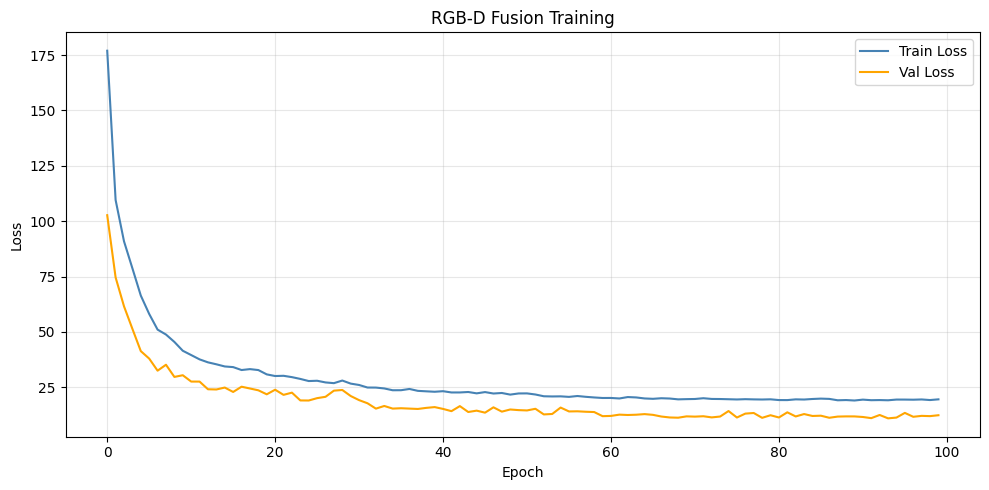

📊 Final losses:
   Train: 19.5043
   Val: 12.3270
   Best Val: 10.9210


In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', color='steelblue')
ax.plot(val_losses, label='Val Loss', color='orange')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('RGB-D Fusion Training')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final losses:")
print(f"Train: {train_losses[-1]:.4f}")
print(f"Val: {val_losses[-1]:.4f}")
print(f"Best Val: {best_val_loss:.4f}")

# Step 7: Testing and Evaluation

Load the best model and evaluate on test set with comprehensive metrics:
- **ADD metric**: Average Distance of Model Points
- **ADD-S metric**: For symmetric objects
- **Accuracy**: Percentage of predictions within threshold
- **Per-object performance**: Breakdown by object class
- **Visualizations**: Qualitative results

In [10]:
# Load best
best_checkpoint_path = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512' / 'best.pt'

if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path, map_location=Config.DEVICE)
    
    # Load weights
    rgb_encoder_train.load_state_dict(checkpoint['rgb_encoder'])
    depth_encoder_train.load_state_dict(checkpoint['depth_encoder'])
    meta_encoder_train.load_state_dict(checkpoint['meta_encoder'])
    pose_regressor_train.load_state_dict(checkpoint['pose_regressor'])
    
    rgb_encoder_train = rgb_encoder_train.to(Config.DEVICE)
    depth_encoder_train = depth_encoder_train.to(Config.DEVICE)
    meta_encoder_train = meta_encoder_train.to(Config.DEVICE)
    pose_regressor_train = pose_regressor_train.to(Config.DEVICE)
    
    print(f"Best checkpoint loaded from: {best_checkpoint_path}")
    print(f"Device: {Config.DEVICE}")
    print(f"Epoch: {checkpoint['epoch'] + 1}")
    print(f"Val Loss: {checkpoint['val_loss']:.4f}")
    
    # Set to eval mode
    rgb_encoder_train.eval()
    depth_encoder_train.eval()
    meta_encoder_train.eval()
    pose_regressor_train.eval()
else:
    print(f"No checkpoint found at {best_checkpoint_path}")
    print(f"Using current model weights (may not be optimal)")

Best checkpoint loaded from: /Users/ale/Documents/polito/AML/polito-aml-6D-pose-estimation/checkpoints/pose/fusion_rgbd_512/best.pt
Device: mps
Epoch: 94
Val Loss: 10.9210


In [12]:
# Load 3D models and info for ADD metric computation
from utils.metrics import compute_add_batch_full_pose
from utils.file_io import load_all_models, load_models_info

# Load models
models_info = load_models_info(Config.MODELS_PATH / 'models_info.yml')
models_dict = load_all_models(Config.MODELS_PATH)

print(f"\nReady for ADD metric computation")
print(f"Objects loaded: {len(models_dict)}")

[load_all_models] VERBOSE - Loading data
[load_all_models] Loaded model 01: 5841 points
[load_all_models] Loaded model 02: 38325 points
[load_all_models] Loaded model 04: 18995 points
[load_all_models] Loaded model 05: 22831 points
[load_all_models] Loaded model 06: 15736 points
[load_all_models] Loaded model 08: 12655 points
[load_all_models] Loaded model 09: 7912 points
[load_all_models] Loaded model 10: 18473 points
[load_all_models] Loaded model 11: 7479 points
[load_all_models] Loaded model 12: 15972 points
[load_all_models] Loaded model 13: 18216 points
[load_all_models] Loaded model 14: 27435 points
[load_all_models] Loaded model 15: 16559 points

Ready for ADD metric computation
Objects loaded: 13


In [13]:
# Run inference on test set
from utils.transforms import quaternion_to_rotation_matrix_batch

# Create test dataloader
test_loader = DataLoader(test_dataset_fusion, batch_size=TRAIN_CONFIG['batch_size'], 
                         shuffle=False, num_workers=0)

# Storage for predictions and ground truth
all_pred_R = []
all_pred_t = []
all_gt_R = []
all_gt_t = []
all_obj_ids = []
print(f"Inference test over {len(test_dataset_fusion)} samples")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        rgb = batch['rgb'].to(Config.DEVICE)
        depth = batch['depth'].to(Config.DEVICE)
        gt_quat = batch['quaternion'].to(Config.DEVICE)
        gt_trans = batch['translation'].to(Config.DEVICE)
        meta = batch['meta'].to(Config.DEVICE)
        
        # Forward pass
        f_rgb = rgb_encoder_train(rgb).squeeze(-1).squeeze(-1)
        f_depth = depth_encoder_train(depth)
        f_meta = meta_encoder_train(meta)
        f_fused = torch.cat([f_rgb, f_depth, f_meta], dim=1)
        pose = pose_regressor_train(f_fused)
        
        pred_quat = pose[:, :4]
        pred_trans = pose[:, 4:]
        
        # quaternions to rotation matrices
        pred_R = quaternion_to_rotation_matrix_batch(pred_quat.cpu()).to(Config.DEVICE)
        gt_R = quaternion_to_rotation_matrix_batch(gt_quat.cpu()).to(Config.DEVICE)
        
        # Store results
        all_pred_R.append(pred_R)
        all_pred_t.append(pred_trans)
        all_gt_R.append(gt_R)
        all_gt_t.append(gt_trans)
        
        # IDs from batch
        obj_ids_batch = batch['obj_id'].to(Config.DEVICE)
        if isinstance(obj_ids_batch, torch.Tensor):
            obj_ids_batch = obj_ids_batch.tolist()
        all_obj_ids.extend(obj_ids_batch)

# Concatenate all results
all_pred_R = torch.cat(all_pred_R, dim=0)  # (N, 3, 3)
all_pred_t = torch.cat(all_pred_t, dim=0)  # (N, 3)
all_gt_R = torch.cat(all_gt_R, dim=0)      # (N, 3, 3)
all_gt_t = torch.cat(all_gt_t, dim=0)      # (N, 3)

print(f"Inference complete!")
print(f"Total predictions: {len(all_pred_R)}")
print(f"Unique objects: {len(set(all_obj_ids))}")

Inference test over 3213 samples


Testing: 100%|██████████| 51/51 [00:46<00:00,  1.09it/s]

Inference complete!
Total predictions: 3213
Unique objects: 13


In [14]:
# Compute ADD metrics
print("Computing ADD metrics")

results = compute_add_batch_full_pose(
    pred_R_batch=all_pred_R,
    pred_t_batch=all_pred_t,
    gt_R_batch=all_gt_R,
    gt_t_batch=all_gt_t,
    obj_ids=all_obj_ids,
    models_dict=models_dict,
    models_info=models_info,
    symmetric_objects=Config.SYMMETRIC_OBJECTS,
    threshold=Config.ADD_THRESHOLD
)

# Print overall metrics
print(f"\nOverall Test Results:")
print(f"Mean ADD: {results['mean_add']:.2f} mm")
print(f"Accuracy: {results['accuracy']*100:.2f}% (< {Config.ADD_THRESHOLD*100:.0f}% diameter)")
print(f"Total samples: {len(results['add_values'])}")

Computing ADD metrics

Overall Test Results:
Mean ADD: 6.05 mm
Accuracy: 98.51% (< 10% diameter)
Total samples: 3213


In [23]:
# Per-object analysis
import pandas as pd

per_object_results = {}

for obj_id in set(all_obj_ids):
    # Get indices
    indices = [i for i, oid in enumerate(all_obj_ids) if oid == obj_id]
    
    # Extract metrics for this object
    obj_add_values = [results['add_values'][i] for i in indices]
    obj_is_correct = [results['is_correct'][i] for i in indices]
    
    # Compute statistics
    per_object_results[obj_id] = {
        'count': len(indices),
        'mean_add': np.mean(obj_add_values),
        'median_add': np.median(obj_add_values),
        'std_add': np.std(obj_add_values),
        'accuracy': np.mean(obj_is_correct) * 100,
        'diameter': models_info[obj_id]['diameter'],
        'symmetric': obj_id in Config.SYMMETRIC_OBJECTS
    }

# Create DataFrame for better visualization
df_results = pd.DataFrame.from_dict(per_object_results, orient='index')
df_results.index.name = 'Object ID'
df_results = df_results.sort_values('accuracy', ascending=False)

print("\nPer-Object Performance")
display(df_results.round(3))

# Summary statistics
print(f"\n✅  Summary Statistics")
print(f"   Best accuracy: {df_results['accuracy'].max():.2f}% (Object {df_results['accuracy'].idxmax()})")
print(f"   Worst accuracy: {df_results['accuracy'].min():.2f}% (Object {df_results['accuracy'].idxmin()})")
print(f"   Mean accuracy: {df_results['accuracy'].mean():.2f}%")
print(f"   Median accuracy: {df_results['accuracy'].median():.2f}%")


Per-Object Performance


,count,mean_add,median_add,std_add,accuracy,diameter,symmetric
Object ID,,,,,,,
10,188,2.333,2.154,1.097,100.000,164.628,True
11,184,2.390,2.267,1.055,100.000,175.889,True
1,187,4.332,4.087,1.975,98.930,102.099,False
12,186,5.498,4.866,3.240,98.925,145.543,False
15,184,7.450,6.922,3.918,98.913,212.358,False
13,173,9.152,7.488,5.761,98.844,278.078,False
4,1020,5.487,4.655,3.943,98.431,172.492,False
14,185,8.926,7.333,7.175,98.378,282.601,False
2,181,8.484,7.445,5.202,98.343,247.506,False



✅  Summary Statistics
   Best accuracy: 100.00% (Object 10)
   Worst accuracy: 96.61% (Object 6)
   Mean accuracy: 98.53%
   Median accuracy: 98.43%


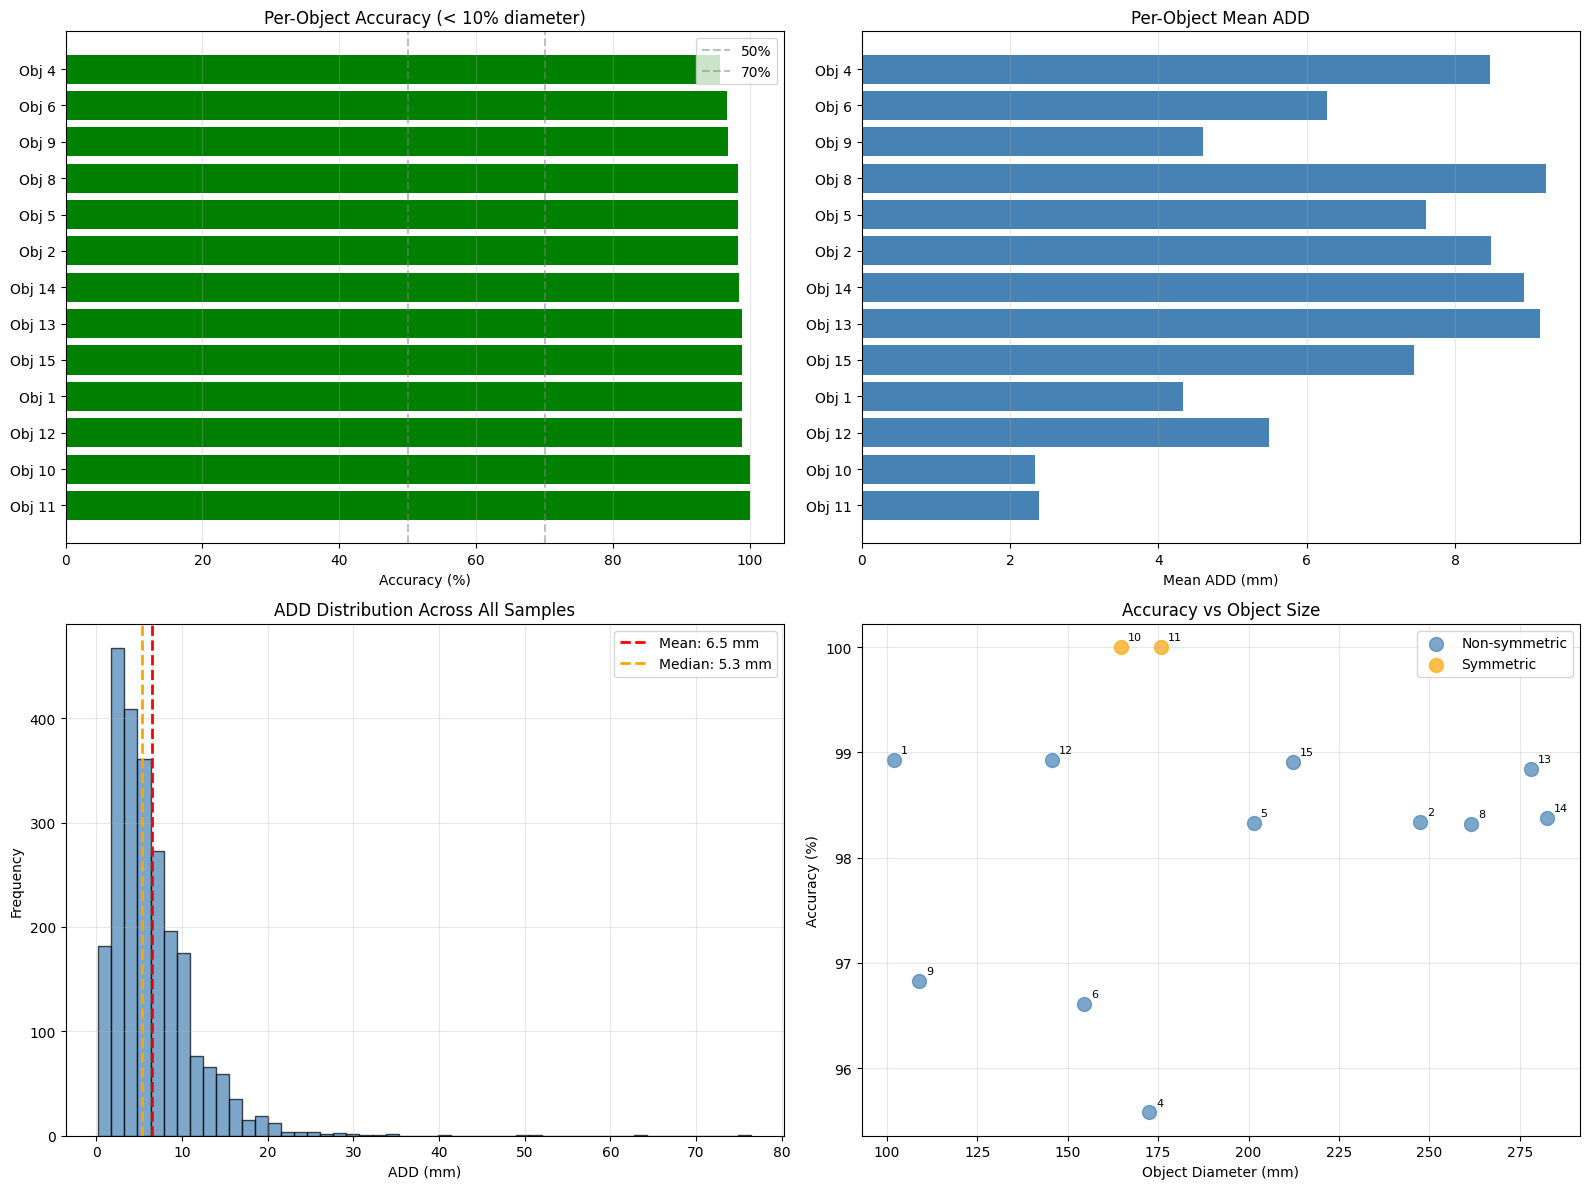

In [28]:
# Visualize per-object results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy by object
ax1 = axes[0, 0]
colors = ['green' if acc >= 70 else 'orange' if acc >= 50 else 'red' 
          for acc in df_results['accuracy']]
ax1.barh(range(len(df_results)), df_results['accuracy'], color=colors)
ax1.set_yticks(range(len(df_results)))
ax1.set_yticklabels([f"Obj {idx}" for idx in df_results.index])
ax1.set_xlabel('Accuracy (%)')
ax1.set_title('Per-Object Accuracy (< 10% diameter)')
ax1.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='50%')
ax1.axvline(x=70, color='gray', linestyle='--', alpha=0.5, label='70%')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Mean ADD by object
ax2 = axes[0, 1]
ax2.barh(range(len(df_results)), df_results['mean_add'], color='steelblue')
ax2.set_yticks(range(len(df_results)))
ax2.set_yticklabels([f"Obj {idx}" for idx in df_results.index])
ax2.set_xlabel('Mean ADD (mm)')
ax2.set_title('Per-Object Mean ADD')
ax2.grid(True, alpha=0.3, axis='x')

# 3. ADD distribution (histogram)
ax3 = axes[1, 0]
ax3.hist(results['add_values'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(x=results['mean_add'], color='red', linestyle='--', linewidth=2, label=f'Mean: {results["mean_add"]:.1f} mm')
ax3.axvline(x=np.median(results['add_values']), color='orange', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(results["add_values"]):.1f} mm')
ax3.set_xlabel('ADD (mm)')
ax3.set_ylabel('Frequency')
ax3.set_title('ADD Distribution Across All Samples')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Accuracy vs Object Diameter
ax4 = axes[1, 1]
symmetric_mask = df_results['symmetric']
ax4.scatter(df_results[~symmetric_mask]['diameter'], 
           df_results[~symmetric_mask]['accuracy'],
           c='steelblue', s=100, alpha=0.7, label='Non-symmetric')
ax4.scatter(df_results[symmetric_mask]['diameter'], 
           df_results[symmetric_mask]['accuracy'],
           c='orange', s=100, alpha=0.7, label='Symmetric')

# Annotate points
for idx, row in df_results.iterrows():
    ax4.annotate(f'{idx}', (row['diameter'], row['accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax4.set_xlabel('Object Diameter (mm)')
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Accuracy vs Object Size')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.spatial.transform import Rotation as R_scipy
import torch.nn.functional as F

rotation_errors = [] #deg

for i in range(len(all_pred_R)):
    # relative rotation: R_error = R_pred^T @ R_gt
    R_error = all_pred_R[i].T @ all_gt_R[i]
    
    # Convert to CPU and numpy before using scipy
    R_error_np = R_error.cpu().numpy()
    
    # Convert to angle-axis and extract angle
    r = R_scipy.from_matrix(R_error_np)
    angle = np.linalg.norm(r.as_rotvec())  # Rotation angle in radians
    angle_deg = np.degrees(angle)
    
    rotation_errors.append(angle_deg)
    # Translation errors (in mm)
    translation_errors = torch.norm(all_pred_t - all_gt_t, dim=1).cpu().numpy() * 1000  # Convert to mm
    R_error = all_pred_R[i].T @ all_gt_R[i]
    
    # Convert to CPU and numpy before using scipy
    R_error_np = R_error.cpu().numpy()
    
    # Convert to angle-axis and extract angle
    r = R_scipy.from_matrix(R_error_np)
    angle = np.linalg.norm(r.as_rotvec())  # Rotation angle in radians
    angle_deg = np.degrees(angle)
    
    rotation_errors.append(angle_deg)

rotation_errors = np.array(rotation_errors)

print(f"\n🔄 Rotation Errors:")
print(f"   Mean: {rotation_errors.mean():.2f}°")
print(f"   Median: {np.median(rotation_errors):.2f}°")
print(f"   Std: {rotation_errors.std():.2f}°")
print(f"   Max: {rotation_errors.max():.2f}°")

print(f"\n↔️ Translation Errors:")
# Translation errors (mm)
translation_errors = F.smooth_l1_loss(all_pred_t*1000, all_gt_t*1000).cpu().numpy()  # Convert to mm
print(f"   Std: {translation_errors.std():.2f} mm")
print(f"   Max: {translation_errors.max():.2f} mm")

# Accuracy at different thresholds (for paper)
thresholds = [0.02, 0.05, 0.10, 0.15, 0.20]  # Fractions of diameter

print(f"\n🎯 Accuracy at Different Thresholds:")
for thresh in thresholds:
    # Recompute ADD metric with this threshold
    results_thresh = compute_add_batch_full_pose(
        pred_R_batch=all_pred_R,
        pred_t_batch=all_pred_t,
        gt_R_batch=all_gt_R,
        gt_t_batch=all_gt_t,
        obj_ids=all_obj_ids,
        models_dict=models_dict,
        models_info=models_info,
        symmetric_objects=Config.SYMMETRIC_OBJECTS,
        threshold=thresh
    )
    print(f"   {thresh*100:2.0f}% diameter: {results_thresh['accuracy']*100:5.2f}%")


🔄 Rotation Errors:
   Mean: 7.68°
   Median: 6.50°
   Std: 5.38°
   Max: 81.46°

↔️ Translation Errors:
   Std: 0.00 mm
   Max: 7.11 mm

🎯 Accuracy at Different Thresholds:
    2% diameter: 30.69%
    5% diameter: 83.85%
   10% diameter: 98.51%
   15% diameter: 99.60%
   20% diameter: 99.81%


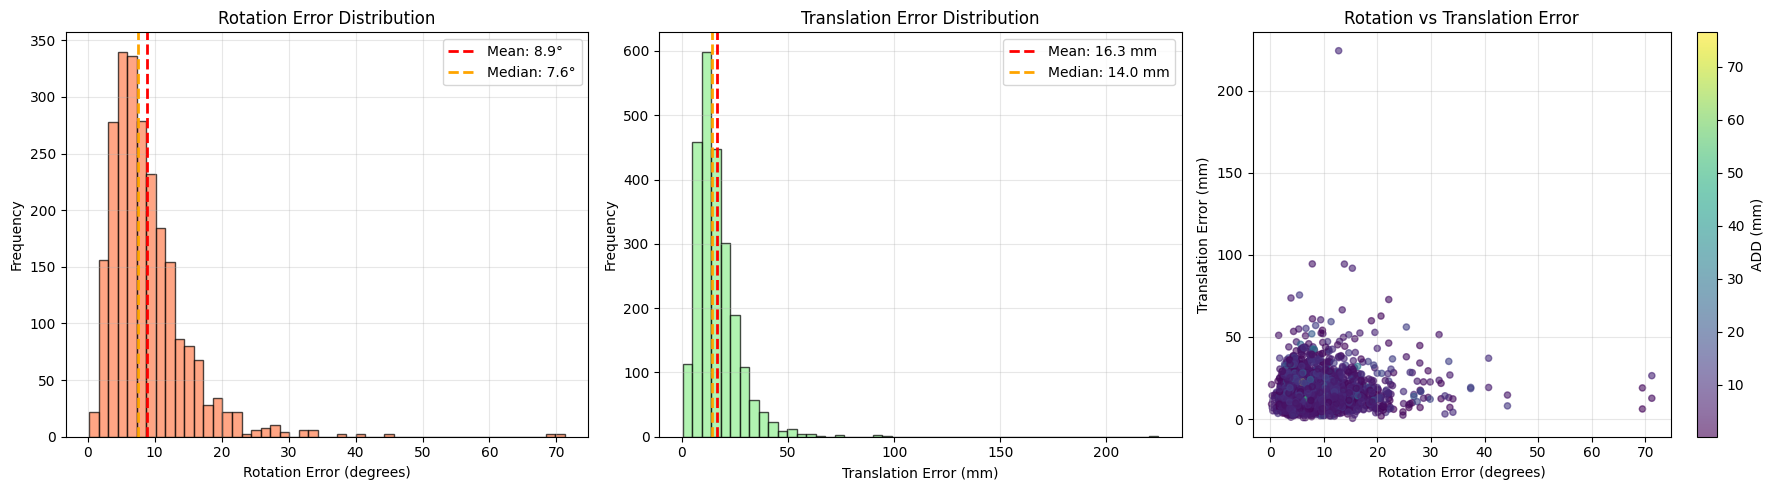


✅ Error analysis complete!


In [24]:
# Compute per-sample translation errors (in mm)
translation_errors = torch.norm(all_pred_t - all_gt_t, dim=1).cpu().numpy() * 1000

# Visualize rotation and translation errors
# Ensure rotation_errors and translation_errors have the same length
rotation_errors_plot = rotation_errors[:len(translation_errors)]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Rotation error distribution
ax1 = axes[0]
ax1.hist(rotation_errors_plot, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax1.axvline(x=rotation_errors_plot.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {rotation_errors_plot.mean():.1f}°')
ax1.axvline(x=np.median(rotation_errors_plot), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(rotation_errors_plot):.1f}°')
ax1.set_xlabel('Rotation Error (degrees)')
ax1.set_ylabel('Frequency')
ax1.set_title('Rotation Error Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Translation error distribution
ax2 = axes[1]
ax2.hist(translation_errors, bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
ax2.axvline(x=translation_errors.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {translation_errors.mean():.1f} mm')
ax2.axvline(x=np.median(translation_errors), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(translation_errors):.1f} mm')
ax2.set_xlabel('Translation Error (mm)')
ax2.set_ylabel('Frequency')
ax2.set_title('Translation Error Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rotation vs Translation error scatter
ax3 = axes[2]
scatter = ax3.scatter(rotation_errors_plot, translation_errors, 
                     c=results['add_values'], cmap='viridis', 
                     alpha=0.6, s=20)
ax3.set_xlabel('Rotation Error (degrees)')
ax3.set_ylabel('Translation Error (mm)')
ax3.set_title('Rotation vs Translation Error')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('ADD (mm)')

plt.tight_layout()
plt.show()

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20780\195682906.py:55: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


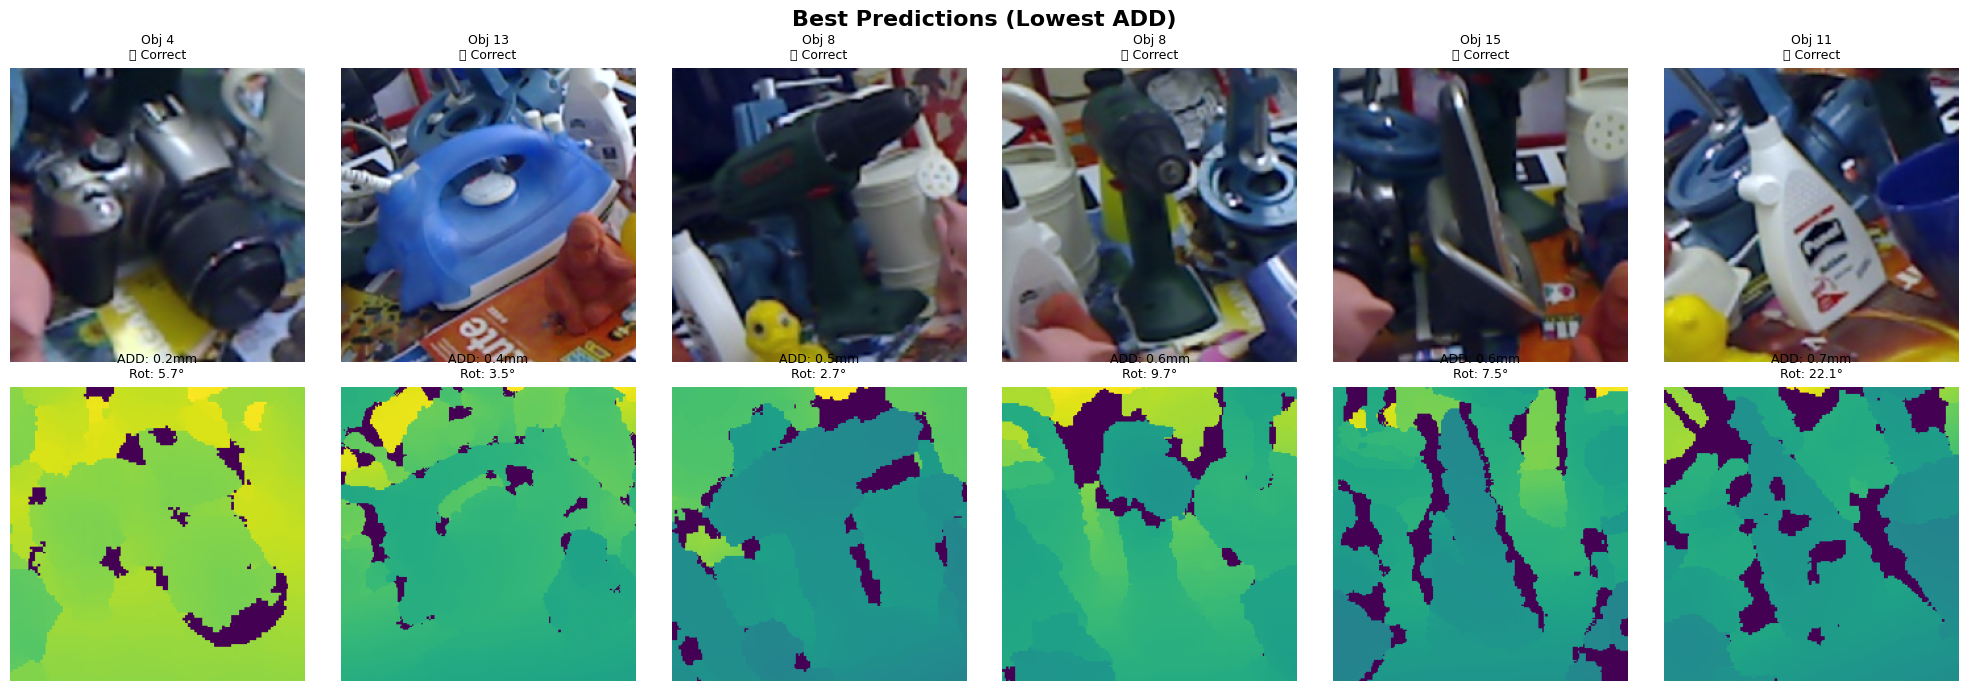

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20780\195682906.py:77: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


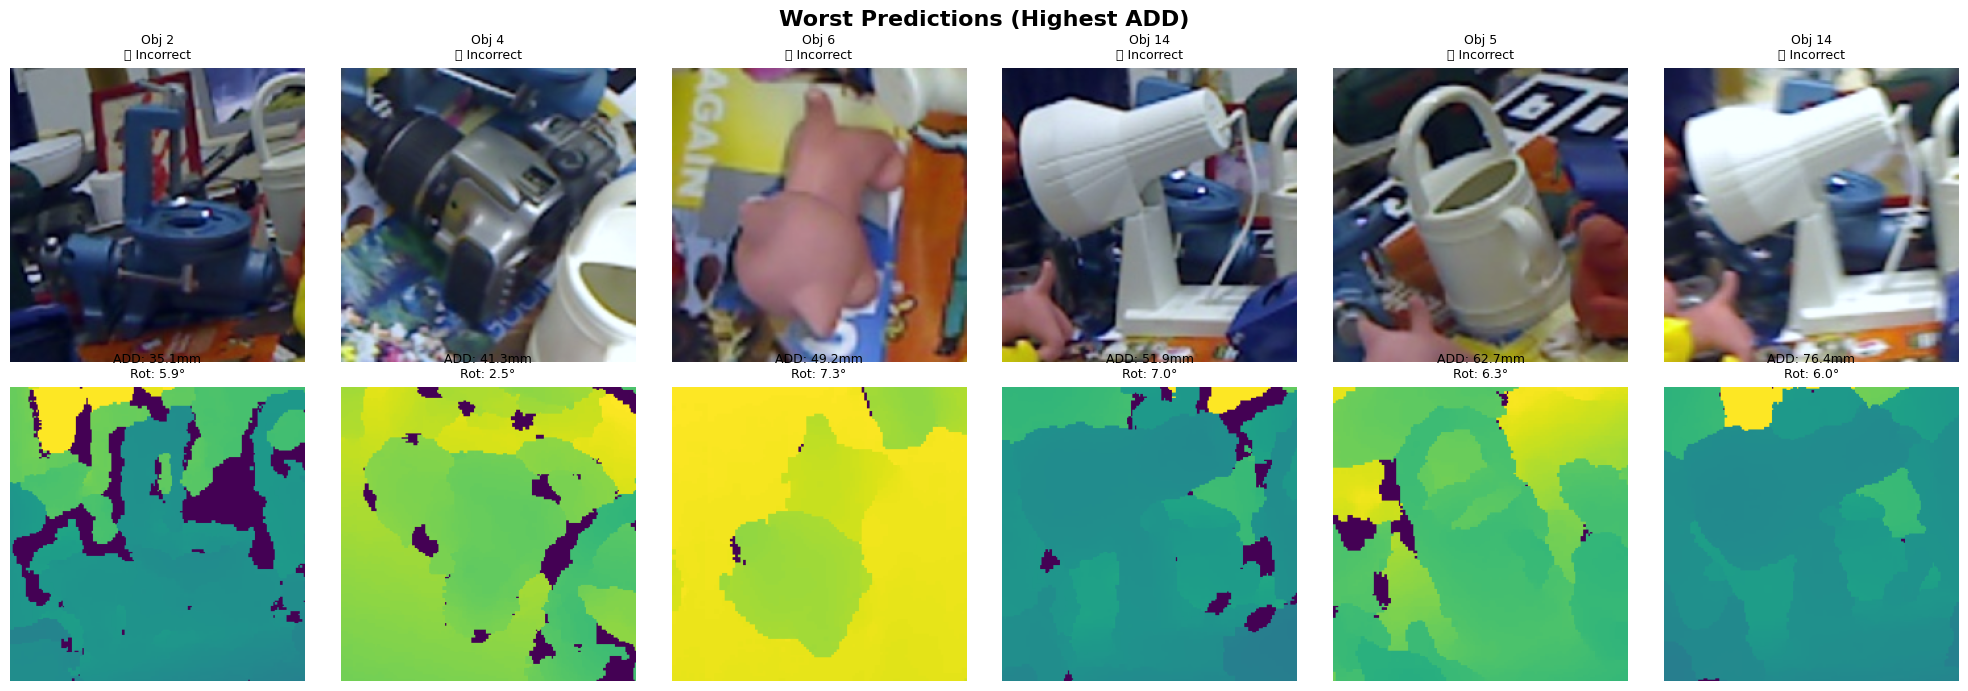


✅ Qualitative results visualized!


In [31]:
# Qualitative visualization: show best and worst predictions
# Find best and worst samples
add_array = np.array(results['add_values'])
best_indices = np.argsort(add_array)[:6]  # Top 6 best
worst_indices = np.argsort(add_array)[-6:]  # Top 6 worst

def visualize_prediction(idx, title_prefix=""):
    """Visualize a single prediction."""
    # Get the sample from test dataset
    sample = test_dataset_fusion[idx]
    
    # Get predictions
    pred_R = all_pred_R[idx]
    pred_t = all_pred_t[idx]
    gt_R = all_gt_R[idx]
    gt_t = all_gt_t[idx]
    
    # Get object info
    obj_id = all_obj_ids[idx]
    add_value = results['add_values'][idx]
    is_correct = results['is_correct'][idx]
    
    # Display info
    status = "✅ Correct" if is_correct else "❌ Incorrect"
    
    return {
        'rgb': sample['rgb'].permute(1, 2, 0).numpy(),
        'depth': sample['depth'].squeeze().numpy(),
        'obj_id': obj_id,
        'add': add_value,
        'status': status,
        'rot_error': rotation_errors[idx],
        'trans_error': translation_errors[idx]
    }

# Visualize best predictions
fig, axes = plt.subplots(2, 6, figsize=(20, 7))
fig.suptitle('Best Predictions (Lowest ADD)', fontsize=16, fontweight='bold')

for i, idx in enumerate(best_indices):
    info = visualize_prediction(idx, "Best")
    
    # RGB
    ax_rgb = axes[0, i]
    ax_rgb.imshow((info['rgb'] * 0.229 + 0.456).clip(0, 1))  # Denormalize (approximate)
    ax_rgb.set_title(f"Obj {info['obj_id']}\n{info['status']}", fontsize=9)
    ax_rgb.axis('off')
    
    # Depth
    ax_depth = axes[1, i]
    ax_depth.imshow(info['depth'], cmap='viridis')
    ax_depth.set_title(f"ADD: {info['add']:.1f}mm\nRot: {info['rot_error']:.1f}°", fontsize=9)
    ax_depth.axis('off')

plt.tight_layout()
plt.show()

# Visualize worst predictions
fig, axes = plt.subplots(2, 6, figsize=(20, 7))
fig.suptitle('Worst Predictions (Highest ADD)', fontsize=16, fontweight='bold')

for i, idx in enumerate(worst_indices):
    info = visualize_prediction(idx, "Worst")
    
    # RGB
    ax_rgb = axes[0, i]
    ax_rgb.imshow((info['rgb'] * 0.229 + 0.456).clip(0, 1))  # Denormalize (approximate)
    ax_rgb.set_title(f"Obj {info['obj_id']}\n{info['status']}", fontsize=9)
    ax_rgb.axis('off')
    
    # Depth
    ax_depth = axes[1, i]
    ax_depth.imshow(info['depth'], cmap='viridis')
    ax_depth.set_title(f"ADD: {info['add']:.1f}mm\nRot: {info['rot_error']:.1f}°", fontsize=9)
    ax_depth.axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Qualitative results visualized!")

In [32]:
# Summary table for paper
summary_table = pd.DataFrame({
    'Metric': [
        'Overall Accuracy (10% diameter)',
        'Mean ADD (mm)',
        'Median ADD (mm)',
        'Mean Rotation Error (°)',
        'Median Rotation Error (°)',
        'Mean Translation Error (mm)',
        'Median Translation Error (mm)',
        'Test Samples',
        'Objects',
        'Model Parameters'
    ],
    'Value': [
        f"{results['accuracy']*100:.2f}%",
        f"{results['mean_add']:.2f}",
        f"{np.median(results['add_values']):.2f}",
        f"{rotation_errors.mean():.2f}",
        f"{np.median(rotation_errors):.2f}",
        f"{translation_errors.mean():.2f}",
        f"{np.median(translation_errors):.2f}",
        f"{len(test_dataset_fusion)}",
        f"{len(set(all_obj_ids))}",
        f"{sum(p.numel() for p in all_params):,}"
    ]
})

print("\n" + "="*60)
print("📋 FINAL RESULTS SUMMARY - RGB-D FUSION MODEL")
print("="*60)
print(summary_table.to_string(index=False))
print("="*60)

# Export results to CSV for paper
results_dir = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512'
df_results.to_csv(results_dir / 'per_object_results.csv')
summary_table.to_csv(results_dir / 'summary_results.csv', index=False)

print(f"\n✅ Results saved to: {results_dir}")
print(f"   - per_object_results.csv")
print(f"   - summary_results.csv")


📋 FINAL RESULTS SUMMARY - RGB-D FUSION MODEL
                         Metric      Value
Overall Accuracy (10% diameter)     98.31%
                  Mean ADD (mm)       6.48
                Median ADD (mm)       5.34
        Mean Rotation Error (°)       8.48
      Median Rotation Error (°)       7.28
    Mean Translation Error (mm)      16.28
  Median Translation Error (mm)      14.03
                   Test Samples       2373
                        Objects         13
               Model Parameters 14,505,255

✅ Results saved to: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\pose\fusion_rgbd_512
   - per_object_results.csv
   - summary_results.csv
